In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from lifelines.utils import concordance_index as cindex
import keras
from keras.models import Sequential, Model
from keras import optimizers, layers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Dense, Activation, Dropout
from keras.models import load_model
from keras.models import model_from_json
from sksurv.preprocessing import OneHotEncoder
import data_prep as dp
import loss_function as lf
from sklearn.model_selection import train_test_split, StratifiedKFold
from lifelines import KaplanMeierFitter
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras import optimizers
from keras.optimizers import RMSprop, SGD, Adam

import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args
from skopt.plots import plot_objective
from sklearn.model_selection import KFold

from tqdm import tqdm
import shap
shap.initjs()

/home/an/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
clinic_df = pd.read_csv("../data/data2.csv")
clean_df = clinic_df.dropna(subset=['event_os','lday'],axis='rows')
clean_df = clean_df[clean_df.lday>0]
clean_df = clean_df[["dx_to_sct_group","source","pt_age_group2","pt_sex","donor_sex",
                    "sex_mismatch1","ps24","abo_mismatch","diagnosis", "cond",
                    "gvhd_pro", "tcd_invivo", "serogvhmis6abdr","stage10",'HLA69', 'event_os','lday']]
cat_var = ["dx_to_sct_group","source","pt_age_group2","pt_sex","donor_sex",
           "sex_mismatch1","ps24","abo_mismatch","diagnosis","cond",
          "gvhd_pro", "tcd_invivo", "serogvhmis6abdr","stage10",'HLA69']
predict_var = ['event_os','lday']
#day from diagnosis to transplant
clean_df["dx_to_sct_group"].fillna(9,inplace=True)
clean_df["donor_sex"].fillna(9,inplace=True)
clean_df["sex_mismatch1"].fillna(9, inplace=True)
clean_df["ps24"].fillna(9,inplace=True)
clean_df["abo_mismatch"].fillna(9,inplace=True)
clean_df["cond"].fillna(9,inplace=True)
# may need to take out disease_status since there are lots of missing value here
clean_df["serogvhmis6abdr"].fillna(9, inplace=True)
clean_df["stage10"].fillna(9, inplace=True)
clean_df["HLA69"].fillna(9, inplace=True)

for i in cat_var:
    clean_df[i] = clean_df[i].astype("category")

include_var = cat_var+predict_var
select_df = clean_df[include_var]

data_x_numeric = OneHotEncoder().fit_transform(select_df)

In [3]:
np.random.seed(67)
data_x_numeric = data_x_numeric.reindex(np.random.permutation(data_x_numeric.index)).sort_values("event_os")
n, d = data_x_numeric.shape

breaks = np.arange(0,8798,365/2)
n_intervals = len(breaks)-1

testing_columns = data_x_numeric.columns.drop(["event_os","lday"])
t = data_x_numeric.lday.values
f = data_x_numeric.event_os.values
x_full = data_x_numeric[testing_columns].values
y_full = dp.make_surv_array(t,f,breaks)
k_ini = keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=67)

k = 5
assignments = np.array((n // k + 1) * list(range(1, k + 1)))
assignments = assignments[:n]

In [4]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation, dropout):
    model = Sequential()
    model.add(Dense(num_dense_nodes, activation = activation, input_dim=60,kernel_initializer=k_ini,bias_initializer=k_ini))
    model.add(Dropout(dropout))
    
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)
        
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))
        model.add(Dropout(dropout))

    model.add(Dense(n_intervals, activation='sigmoid'))
    optimizer = Adam(lr=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss=lf.surv_likelihood(n_intervals),
                  metrics=["accuracy"]
                 )
  
    return model

In [5]:
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=1, high=1024, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', "selu", "elu", "sigmoid", "tanh"],name='activation')
dim_dropout = Real(low=0.1, high=0.5, prior='log-uniform',name='dropout')

dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
              dim_dropout]
default_parameters = [0.01, 2, 160, 'relu', 0.1]

In [6]:
early_stopping = EarlyStopping(monitor='loss', patience=2)
best_c_index_result = 0.0
path_best_model = "../model/nsvv17.h5"

In [7]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation, dropout):

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print("dropout:", dropout)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         dropout=dropout)
    
    c_index_result = []
    for i in range(1,k+1):
        print("fold: ",i)
        ix = assignments == i
        training_data = data_x_numeric.loc[~ix]
        testing_data = data_x_numeric.loc[ix]

        t_train = training_data.lday.values
        f_train = training_data.event_os.values
        x_train = training_data[testing_columns].values
        y_train = dp.make_surv_array(t_train,f_train,breaks)

        t_test = testing_data.lday.values
        f_test = testing_data.event_os.values
        x_test = testing_data[testing_columns].values
        y_test = dp.make_surv_array(t_test,f_test,breaks)


        # Use Keras to train the model.
        history = model.fit(x=x_train,
                            y=y_train,
                            epochs=1000,
                            batch_size=216,
                            validation_data=(x_test,y_test),
                            callbacks=[early_stopping])

        y_pred_test = model.predict_proba(x_test)

        out_pred = []
        for h in range(len(y_pred_test)):
            temp = np.cumprod(y_pred_test[h,:])>0.5
            pred = (365/2)*list(temp).count(True)
            out_pred.append(pred)
        c_index = cindex(t_test,out_pred,f_test)
        c_index_result.append(c_index)
         
    c_index_result = np.mean(c_index_result)
    print("C_index_resut: {0:.2%}".format(c_index_result))
    print()
    
    global best_c_index_result
    
    if c_index_result > best_c_index_result:
        model.save(path_best_model)
        best_c_index_result = c_index_result
               
    del model

    return -c_index_result

In [8]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-02
num_dense_layers: 2
num_dense_nodes: 160
activation: relu
dropout: 0.1

fold:  1
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 1s 1ms/step - loss: 4.8790 - acc: 0.0405 - val_loss: 2.7767 - val_acc: 0.0000e+00
Epoch 2/1000
469/469 [==============================] - 0s 45us/step - loss: 2.3744 - acc: 0.0000e+00 - val_loss: 1.8281 - val_acc: 0.0000e+00
Epoch 3/1000
469/469 [==============================] - 0s 67us/step - loss: 1.7294 - acc: 0.0000e+00 - val_loss: 1.7499 - val_acc: 0.0000e+00
Epoch 4/1000
469/469 [==============================] - 0s 91us/step - loss: 1.5860 - acc: 0.0000e+00 - val_loss: 1.6971 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 96us/step - loss: 1.4859 - acc: 0.0000e+00 - val_loss: 1.6643 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 105us/step - loss: 1.4045 - acc: 0.0000e+00 - val_loss: 1.6722 - val_acc: 0.0000e

469/469 [==============================] - 0s 74us/step - loss: 0.4234 - acc: 0.0896 - val_loss: 1.0175 - val_acc: 0.0593
Epoch 14/1000
469/469 [==============================] - 0s 67us/step - loss: 0.3789 - acc: 0.1301 - val_loss: 1.1602 - val_acc: 0.1186
Epoch 15/1000
469/469 [==============================] - 0s 80us/step - loss: 0.3564 - acc: 0.1791 - val_loss: 1.1246 - val_acc: 0.1186
Epoch 16/1000
469/469 [==============================] - 0s 97us/step - loss: 0.3330 - acc: 0.1599 - val_loss: 1.1568 - val_acc: 0.1610
Epoch 17/1000
469/469 [==============================] - 0s 70us/step - loss: 0.3284 - acc: 0.1983 - val_loss: 1.2085 - val_acc: 0.1695
Epoch 18/1000
469/469 [==============================] - 0s 54us/step - loss: 0.3135 - acc: 0.2132 - val_loss: 1.3164 - val_acc: 0.1695
Epoch 19/1000
469/469 [==============================] - 0s 73us/step - loss: 0.2701 - acc: 0.2111 - val_loss: 1.3209 - val_acc: 0.1610
Epoch 20/1000
469/469 [==============================] - 0s 83

469/469 [==============================] - 0s 104us/step - loss: 5.8989 - acc: 0.0021 - val_loss: 5.6404 - val_acc: 0.0000e+00
Epoch 3/1000
469/469 [==============================] - 0s 82us/step - loss: 5.8994 - acc: 0.0000e+00 - val_loss: 5.6403 - val_acc: 0.0000e+00
fold:  3
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 72us/step - loss: 5.7441 - acc: 0.0000e+00 - val_loss: 6.2522 - val_acc: 0.0000e+00
Epoch 2/1000
470/470 [==============================] - 0s 106us/step - loss: 5.7472 - acc: 0.0000e+00 - val_loss: 6.2520 - val_acc: 0.0000e+00
Epoch 3/1000
470/470 [==============================] - 0s 85us/step - loss: 5.7456 - acc: 0.0000e+00 - val_loss: 6.2519 - val_acc: 0.0000e+00
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 89us/step - loss: 5.9671 - acc: 0.0000e+00 - val_loss: 5.3544 - val_acc: 0.0000e+00
Epoch 2/1000
470/470 [=========================

469/469 [==============================] - 0s 637us/step - loss: 2.3828 - acc: 0.0000e+00 - val_loss: 2.4507 - val_acc: 0.0000e+00
Epoch 45/1000
469/469 [==============================] - 0s 633us/step - loss: 2.3239 - acc: 0.0000e+00 - val_loss: 2.4045 - val_acc: 0.0000e+00
Epoch 46/1000
469/469 [==============================] - 0s 620us/step - loss: 2.3004 - acc: 0.0000e+00 - val_loss: 2.3597 - val_acc: 0.0000e+00
Epoch 47/1000
469/469 [==============================] - 0s 611us/step - loss: 2.2492 - acc: 0.0000e+00 - val_loss: 2.3173 - val_acc: 0.0000e+00
Epoch 48/1000
469/469 [==============================] - 0s 675us/step - loss: 2.2059 - acc: 0.0000e+00 - val_loss: 2.2763 - val_acc: 0.0000e+00
Epoch 49/1000
469/469 [==============================] - 0s 611us/step - loss: 2.1793 - acc: 0.0000e+00 - val_loss: 2.2366 - val_acc: 0.0000e+00
Epoch 50/1000
469/469 [==============================] - 0s 637us/step - loss: 2.1359 - acc: 0.0000e+00 - val_loss: 2.1996 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 622us/step - loss: 1.5847 - acc: 0.0000e+00 - val_loss: 1.5609 - val_acc: 0.0000e+00
Epoch 16/1000
469/469 [==============================] - 0s 664us/step - loss: 1.5689 - acc: 0.0000e+00 - val_loss: 1.5588 - val_acc: 0.0000e+00
Epoch 17/1000
469/469 [==============================] - 0s 625us/step - loss: 1.5441 - acc: 0.0000e+00 - val_loss: 1.5566 - val_acc: 0.0000e+00
Epoch 18/1000
469/469 [==============================] - 0s 616us/step - loss: 1.5443 - acc: 0.0000e+00 - val_loss: 1.5544 - val_acc: 0.0000e+00
Epoch 19/1000
469/469 [==============================] - 0s 676us/step - loss: 1.5711 - acc: 0.0000e+00 - val_loss: 1.5521 - val_acc: 0.0000e+00
fold:  3
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 614us/step - loss: 1.5462 - acc: 0.0000e+00 - val_loss: 1.5740 - val_acc: 0.0000e+00
Epoch 2/1000
470/470 [==============================] - 0s 613us/step - loss: 1.5591 - acc

470/470 [==============================] - 1s 2ms/step - loss: 1.1151 - acc: 0.0000e+00 - val_loss: 1.0274 - val_acc: 0.0000e+00
Epoch 4/1000
470/470 [==============================] - 1s 2ms/step - loss: 1.1268 - acc: 0.0000e+00 - val_loss: 1.0543 - val_acc: 0.0000e+00
Epoch 5/1000
470/470 [==============================] - 1s 2ms/step - loss: 1.0647 - acc: 0.0000e+00 - val_loss: 1.0836 - val_acc: 0.0000e+00
Epoch 6/1000
470/470 [==============================] - 1s 2ms/step - loss: 1.0622 - acc: 0.0000e+00 - val_loss: 1.1185 - val_acc: 0.0000e+00
Epoch 7/1000
470/470 [==============================] - 1s 2ms/step - loss: 1.0317 - acc: 0.0021 - val_loss: 1.1621 - val_acc: 0.0000e+00
Epoch 8/1000
470/470 [==============================] - 1s 2ms/step - loss: 1.0097 - acc: 0.0000e+00 - val_loss: 1.2044 - val_acc: 0.0000e+00
Epoch 9/1000
470/470 [==============================] - 1s 2ms/step - loss: 1.0037 - acc: 0.0000e+00 - val_loss: 1.2618 - val_acc: 0.0000e+00
Epoch 10/1000
470/470 [

469/469 [==============================] - 0s 145us/step - loss: 5.5146 - acc: 0.0405 - val_loss: 5.7614 - val_acc: 0.0424
Epoch 23/1000
469/469 [==============================] - 0s 148us/step - loss: 5.4932 - acc: 0.0277 - val_loss: 5.7519 - val_acc: 0.0424
Epoch 24/1000
469/469 [==============================] - 0s 138us/step - loss: 5.4807 - acc: 0.0384 - val_loss: 5.7424 - val_acc: 0.0508
Epoch 25/1000
469/469 [==============================] - 0s 143us/step - loss: 5.4920 - acc: 0.0256 - val_loss: 5.7327 - val_acc: 0.0508
Epoch 26/1000
469/469 [==============================] - 0s 151us/step - loss: 5.4651 - acc: 0.0277 - val_loss: 5.7232 - val_acc: 0.0508
Epoch 27/1000
469/469 [==============================] - 0s 132us/step - loss: 5.4462 - acc: 0.0533 - val_loss: 5.7136 - val_acc: 0.0508
Epoch 28/1000
469/469 [==============================] - 0s 140us/step - loss: 5.4549 - acc: 0.0405 - val_loss: 5.7039 - val_acc: 0.0508
Epoch 29/1000
469/469 [==============================] 

Epoch 82/1000
469/469 [==============================] - 0s 147us/step - loss: 4.9503 - acc: 0.1066 - val_loss: 5.1862 - val_acc: 0.1610
Epoch 83/1000
469/469 [==============================] - 0s 138us/step - loss: 4.9335 - acc: 0.0959 - val_loss: 5.1767 - val_acc: 0.1610
Epoch 84/1000
469/469 [==============================] - 0s 145us/step - loss: 4.9316 - acc: 0.0810 - val_loss: 5.1671 - val_acc: 0.1610
Epoch 85/1000
469/469 [==============================] - 0s 151us/step - loss: 4.9226 - acc: 0.1279 - val_loss: 5.1575 - val_acc: 0.1610
Epoch 86/1000
469/469 [==============================] - 0s 130us/step - loss: 4.9133 - acc: 0.1215 - val_loss: 5.1481 - val_acc: 0.1610
Epoch 87/1000
469/469 [==============================] - 0s 138us/step - loss: 4.9044 - acc: 0.1237 - val_loss: 5.1386 - val_acc: 0.1610
Epoch 88/1000
469/469 [==============================] - 0s 155us/step - loss: 4.8879 - acc: 0.0896 - val_loss: 5.1289 - val_acc: 0.1610
Epoch 89/1000
469/469 [==================

fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 130us/step - loss: 4.5171 - acc: 0.1128 - val_loss: 4.0542 - val_acc: 0.1026
Epoch 2/1000
470/470 [==============================] - 0s 161us/step - loss: 4.5028 - acc: 0.1021 - val_loss: 4.0457 - val_acc: 0.1026
Epoch 3/1000
470/470 [==============================] - 0s 154us/step - loss: 4.4989 - acc: 0.1213 - val_loss: 4.0370 - val_acc: 0.1026
Epoch 4/1000
470/470 [==============================] - 0s 125us/step - loss: 4.4770 - acc: 0.1383 - val_loss: 4.0282 - val_acc: 0.1026
Epoch 5/1000
470/470 [==============================] - 0s 139us/step - loss: 4.4732 - acc: 0.1106 - val_loss: 4.0195 - val_acc: 0.1026
Epoch 6/1000
470/470 [==============================] - 0s 157us/step - loss: 4.4679 - acc: 0.1319 - val_loss: 4.0108 - val_acc: 0.1026
Epoch 7/1000
470/470 [==============================] - 0s 132us/step - loss: 4.4631 - acc: 0.1234 - val_loss: 4.0020 - val_acc: 

469/469 [==============================] - 0s 196us/step - loss: 6.0443 - acc: 0.0000e+00 - val_loss: 6.1601 - val_acc: 0.0000e+00
Epoch 14/1000
469/469 [==============================] - 0s 171us/step - loss: 5.9602 - acc: 0.0000e+00 - val_loss: 6.0950 - val_acc: 0.0000e+00
Epoch 15/1000
469/469 [==============================] - 0s 170us/step - loss: 5.8657 - acc: 0.0000e+00 - val_loss: 6.0298 - val_acc: 0.0000e+00
Epoch 16/1000
469/469 [==============================] - 0s 192us/step - loss: 5.8244 - acc: 0.0000e+00 - val_loss: 5.9657 - val_acc: 0.0000e+00
Epoch 17/1000
469/469 [==============================] - 0s 191us/step - loss: 5.7826 - acc: 0.0000e+00 - val_loss: 5.9036 - val_acc: 0.0000e+00
Epoch 18/1000
469/469 [==============================] - 0s 172us/step - loss: 5.7004 - acc: 0.0000e+00 - val_loss: 5.8424 - val_acc: 0.0000e+00
Epoch 19/1000
469/469 [==============================] - 0s 175us/step - loss: 5.5931 - acc: 0.0000e+00 - val_loss: 5.7822 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 171us/step - loss: 3.6259 - acc: 0.0000e+00 - val_loss: 3.7057 - val_acc: 0.0000e+00
Epoch 70/1000
469/469 [==============================] - 0s 157us/step - loss: 3.5727 - acc: 0.0000e+00 - val_loss: 3.6784 - val_acc: 0.0000e+00
Epoch 71/1000
469/469 [==============================] - 0s 167us/step - loss: 3.5415 - acc: 0.0000e+00 - val_loss: 3.6515 - val_acc: 0.0000e+00
Epoch 72/1000
469/469 [==============================] - 0s 212us/step - loss: 3.5420 - acc: 0.0000e+00 - val_loss: 3.6244 - val_acc: 0.0000e+00
Epoch 73/1000
469/469 [==============================] - 0s 175us/step - loss: 3.5408 - acc: 0.0000e+00 - val_loss: 3.5976 - val_acc: 0.0000e+00
Epoch 74/1000
469/469 [==============================] - 0s 175us/step - loss: 3.4882 - acc: 0.0000e+00 - val_loss: 3.5708 - val_acc: 0.0000e+00
Epoch 75/1000
469/469 [==============================] - 0s 193us/step - loss: 3.4461 - acc: 0.0000e+00 - val_loss: 3.5443 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 168us/step - loss: 2.6600 - acc: 0.0000e+00 - val_loss: 2.4274 - val_acc: 0.0000e+00
Epoch 12/1000
469/469 [==============================] - 0s 160us/step - loss: 2.6200 - acc: 0.0000e+00 - val_loss: 2.4170 - val_acc: 0.0000e+00
Epoch 13/1000
469/469 [==============================] - 0s 162us/step - loss: 2.6143 - acc: 0.0000e+00 - val_loss: 2.4071 - val_acc: 0.0000e+00
Epoch 14/1000
469/469 [==============================] - 0s 200us/step - loss: 2.5961 - acc: 0.0000e+00 - val_loss: 2.3974 - val_acc: 0.0000e+00
Epoch 15/1000
469/469 [==============================] - 0s 171us/step - loss: 2.6251 - acc: 0.0000e+00 - val_loss: 2.3880 - val_acc: 0.0000e+00
Epoch 16/1000
469/469 [==============================] - 0s 175us/step - loss: 2.5922 - acc: 0.0000e+00 - val_loss: 2.3788 - val_acc: 0.0000e+00
Epoch 17/1000
469/469 [==============================] - 0s 181us/step - loss: 2.5993 - acc: 0.0000e+00 - val_loss: 2.3694 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 1ms/step - loss: 4.8586 - acc: 0.0618 - val_loss: 4.8874 - val_acc: 0.1695
Epoch 23/1000
469/469 [==============================] - 1s 1ms/step - loss: 4.8235 - acc: 0.0682 - val_loss: 4.8345 - val_acc: 0.1695
Epoch 24/1000
469/469 [==============================] - 0s 1ms/step - loss: 4.7706 - acc: 0.0746 - val_loss: 4.7806 - val_acc: 0.1780
Epoch 25/1000
469/469 [==============================] - 0s 1ms/step - loss: 4.7295 - acc: 0.0810 - val_loss: 4.7266 - val_acc: 0.1864
Epoch 26/1000
469/469 [==============================] - 0s 1ms/step - loss: 4.6864 - acc: 0.0789 - val_loss: 4.6725 - val_acc: 0.2034
Epoch 27/1000
469/469 [==============================] - 0s 1ms/step - loss: 4.6606 - acc: 0.0704 - val_loss: 4.6187 - val_acc: 0.2119
Epoch 28/1000
469/469 [==============================] - 0s 1ms/step - loss: 4.5945 - acc: 0.0661 - val_loss: 4.5642 - val_acc: 0.2288
Epoch 29/1000
469/469 [==============================] - 1s 1ms/step 

469/469 [==============================] - 0s 1ms/step - loss: 2.3183 - acc: 0.0085 - val_loss: 2.1951 - val_acc: 0.0000e+00
Epoch 83/1000
469/469 [==============================] - 0s 1ms/step - loss: 2.2582 - acc: 0.0085 - val_loss: 2.1745 - val_acc: 0.0000e+00
Epoch 84/1000
469/469 [==============================] - 0s 1ms/step - loss: 2.2729 - acc: 0.0128 - val_loss: 2.1546 - val_acc: 0.0000e+00
Epoch 85/1000
469/469 [==============================] - 1s 1ms/step - loss: 2.2406 - acc: 0.0107 - val_loss: 2.1356 - val_acc: 0.0000e+00
Epoch 86/1000
469/469 [==============================] - 0s 1ms/step - loss: 2.1728 - acc: 0.0064 - val_loss: 2.1177 - val_acc: 0.0000e+00
Epoch 87/1000
469/469 [==============================] - 1s 1ms/step - loss: 2.2115 - acc: 0.0107 - val_loss: 2.1004 - val_acc: 0.0000e+00
Epoch 88/1000
469/469 [==============================] - 0s 1ms/step - loss: 2.1573 - acc: 0.0021 - val_loss: 2.0836 - val_acc: 0.0000e+00
Epoch 89/1000
469/469 [==================

469/469 [==============================] - 0s 146us/step - loss: 2.4298 - acc: 0.0000e+00 - val_loss: 2.3189 - val_acc: 0.0000e+00
Epoch 16/1000
469/469 [==============================] - 0s 158us/step - loss: 2.3037 - acc: 0.0021 - val_loss: 2.2417 - val_acc: 0.0000e+00
Epoch 17/1000
469/469 [==============================] - 0s 201us/step - loss: 2.2574 - acc: 0.0000e+00 - val_loss: 2.1740 - val_acc: 0.0000e+00
Epoch 18/1000
469/469 [==============================] - 0s 157us/step - loss: 2.1859 - acc: 0.0000e+00 - val_loss: 2.1142 - val_acc: 0.0000e+00
Epoch 19/1000
469/469 [==============================] - 0s 157us/step - loss: 2.1231 - acc: 0.0000e+00 - val_loss: 2.0607 - val_acc: 0.0000e+00
Epoch 20/1000
469/469 [==============================] - 0s 154us/step - loss: 2.0774 - acc: 0.0000e+00 - val_loss: 2.0127 - val_acc: 0.0000e+00
Epoch 21/1000
469/469 [==============================] - 0s 158us/step - loss: 2.0432 - acc: 0.0000e+00 - val_loss: 1.9697 - val_acc: 0.0000e+00
Epo

Epoch 4/1000
469/469 [==============================] - 0s 239us/step - loss: 1.4152 - acc: 0.0000e+00 - val_loss: 1.3657 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 161us/step - loss: 1.4149 - acc: 0.0000e+00 - val_loss: 1.3804 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 199us/step - loss: 1.4025 - acc: 0.0000e+00 - val_loss: 1.3949 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 181us/step - loss: 1.3815 - acc: 0.0000e+00 - val_loss: 1.4133 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [==============================] - 0s 206us/step - loss: 1.3384 - acc: 0.0000e+00 - val_loss: 1.3951 - val_acc: 0.0000e+00
Epoch 9/1000
469/469 [==============================] - 0s 185us/step - loss: 1.3287 - acc: 0.0000e+00 - val_loss: 1.5724 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==============================] - 0s 205us/step - loss: 1.3517 - acc: 0.0000e+00 - val_loss: 1.9231 - val_acc: 0.

fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 80us/step - loss: 1.6839 - acc: 0.0000e+00 - val_loss: 1.5380 - val_acc: 0.0000e+00
Epoch 2/1000
469/469 [==============================] - 0s 95us/step - loss: 1.5743 - acc: 0.0000e+00 - val_loss: 1.5451 - val_acc: 0.0000e+00
Epoch 3/1000
469/469 [==============================] - 0s 82us/step - loss: 1.6407 - acc: 0.0000e+00 - val_loss: 1.5869 - val_acc: 0.0000e+00
Epoch 4/1000
469/469 [==============================] - 0s 99us/step - loss: 1.6480 - acc: 0.0000e+00 - val_loss: 1.5658 - val_acc: 0.0000e+00
fold:  3
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 76us/step - loss: 1.5962 - acc: 0.0000e+00 - val_loss: 1.4796 - val_acc: 0.0000e+00
Epoch 2/1000
470/470 [==============================] - 0s 105us/step - loss: 1.6052 - acc: 0.0000e+00 - val_loss: 1.5059 - val_acc: 0.0000e+00
Epoch 3/1000
470/470 [=========

Epoch 3/1000
469/469 [==============================] - 1s 2ms/step - loss: 8.5917 - acc: 0.8273 - val_loss: 8.3322 - val_acc: 0.8390
fold:  3
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 1s 2ms/step - loss: 8.6078 - acc: 0.8234 - val_loss: 8.2657 - val_acc: 0.8547
Epoch 2/1000
470/470 [==============================] - 1s 2ms/step - loss: 8.6078 - acc: 0.8234 - val_loss: 8.2657 - val_acc: 0.8547
Epoch 3/1000
470/470 [==============================] - 1s 2ms/step - loss: 8.6078 - acc: 0.8234 - val_loss: 8.2657 - val_acc: 0.8547
Epoch 4/1000
470/470 [==============================] - 1s 2ms/step - loss: 8.6078 - acc: 0.8234 - val_loss: 8.2657 - val_acc: 0.8547
Epoch 5/1000
470/470 [==============================] - 1s 2ms/step - loss: 8.6078 - acc: 0.8234 - val_loss: 8.2657 - val_acc: 0.8547
Epoch 6/1000
470/470 [==============================] - 1s 2ms/step - loss: 8.6077 - acc: 0.8234 - val_loss: 8.2657 - val_acc: 0.8547
Epoch 7

fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 50us/step - loss: 6.4699 - acc: 0.0064 - val_loss: 5.7410 - val_acc: 0.0000e+00
Epoch 2/1000
470/470 [==============================] - 0s 47us/step - loss: 6.4898 - acc: 0.0213 - val_loss: 5.7387 - val_acc: 0.0000e+00
Epoch 3/1000
470/470 [==============================] - 0s 62us/step - loss: 6.5392 - acc: 0.0064 - val_loss: 5.7365 - val_acc: 0.0000e+00
fold:  5
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 67us/step - loss: 6.3533 - acc: 0.0106 - val_loss: 6.4054 - val_acc: 0.0085
Epoch 2/1000
470/470 [==============================] - 0s 105us/step - loss: 6.3532 - acc: 0.0234 - val_loss: 6.4030 - val_acc: 0.0085
Epoch 3/1000
470/470 [==============================] - 0s 71us/step - loss: 6.3454 - acc: 0.0085 - val_loss: 6.4006 - val_acc: 0.0085
Epoch 4/1000
470/470 [==============================] - 0s 70us/ste

469/469 [==============================] - 0s 400us/step - loss: 0.1323 - acc: 0.1770 - val_loss: 4.1575 - val_acc: 0.0678
Epoch 24/1000
469/469 [==============================] - 0s 410us/step - loss: 0.0975 - acc: 0.1770 - val_loss: 4.1883 - val_acc: 0.1186
Epoch 25/1000
469/469 [==============================] - 0s 398us/step - loss: 0.1204 - acc: 0.1962 - val_loss: 4.4899 - val_acc: 0.1864
Epoch 26/1000
469/469 [==============================] - 0s 418us/step - loss: 0.1119 - acc: 0.3753 - val_loss: 4.5699 - val_acc: 0.1356
fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 391us/step - loss: 1.1828 - acc: 0.2473 - val_loss: 0.1181 - val_acc: 0.2119
Epoch 2/1000
469/469 [==============================] - 0s 415us/step - loss: 0.8409 - acc: 0.1834 - val_loss: 0.3259 - val_acc: 0.1186
Epoch 3/1000
469/469 [==============================] - 0s 449us/step - loss: 0.6036 - acc: 0.1237 - val_loss: 0.4283 - val_acc: 0.1271
Epo

Epoch 4/1000
469/469 [==============================] - 0s 69us/step - loss: 1.3587 - acc: 0.0000e+00 - val_loss: 1.3479 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 86us/step - loss: 1.3504 - acc: 0.0000e+00 - val_loss: 1.3655 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 59us/step - loss: 1.3198 - acc: 0.0000e+00 - val_loss: 1.3823 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 102us/step - loss: 1.2965 - acc: 0.0000e+00 - val_loss: 1.3826 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [==============================] - 0s 86us/step - loss: 1.2868 - acc: 0.0000e+00 - val_loss: 1.3771 - val_acc: 0.0000e+00
Epoch 9/1000
469/469 [==============================] - 0s 75us/step - loss: 1.2467 - acc: 0.0000e+00 - val_loss: 1.3681 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==============================] - 0s 82us/step - loss: 1.2404 - acc: 0.0000e+00 - val_loss: 1.3890 - val_acc: 0.0000e+

469/469 [==============================] - 2s 5ms/step - loss: 5.7465 - acc: 0.7612 - val_loss: 5.9225 - val_acc: 0.8220
Epoch 2/1000
469/469 [==============================] - 0s 30us/step - loss: 5.6402 - acc: 0.8316 - val_loss: 5.8151 - val_acc: 0.8220
Epoch 3/1000
469/469 [==============================] - 0s 37us/step - loss: 5.5399 - acc: 0.7740 - val_loss: 5.7058 - val_acc: 0.0000e+00
Epoch 4/1000
469/469 [==============================] - 0s 24us/step - loss: 5.4346 - acc: 0.0000e+00 - val_loss: 5.5990 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 31us/step - loss: 5.3342 - acc: 0.0000e+00 - val_loss: 5.4934 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 38us/step - loss: 5.2354 - acc: 0.0000e+00 - val_loss: 5.3904 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 31us/step - loss: 5.1358 - acc: 0.0000e+00 - val_loss: 5.2910 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [===========

469/469 [==============================] - 0s 35us/step - loss: 2.5229 - acc: 0.0000e+00 - val_loss: 2.5964 - val_acc: 0.0000e+00
Epoch 59/1000
469/469 [==============================] - 0s 84us/step - loss: 2.5010 - acc: 0.0000e+00 - val_loss: 2.5739 - val_acc: 0.0000e+00
Epoch 60/1000
469/469 [==============================] - 0s 59us/step - loss: 2.4805 - acc: 0.0000e+00 - val_loss: 2.5517 - val_acc: 0.0000e+00
Epoch 61/1000
469/469 [==============================] - 0s 60us/step - loss: 2.4599 - acc: 0.0000e+00 - val_loss: 2.5298 - val_acc: 0.0000e+00
Epoch 62/1000
469/469 [==============================] - 0s 51us/step - loss: 2.4395 - acc: 0.0000e+00 - val_loss: 2.5083 - val_acc: 0.0000e+00
Epoch 63/1000
469/469 [==============================] - 0s 65us/step - loss: 2.4195 - acc: 0.0000e+00 - val_loss: 2.4872 - val_acc: 0.0000e+00
Epoch 64/1000
469/469 [==============================] - 0s 34us/step - loss: 2.3995 - acc: 0.0000e+00 - val_loss: 2.4667 - val_acc: 0.0000e+00
Epoch 

Epoch 115/1000
469/469 [==============================] - 0s 30us/step - loss: 1.8542 - acc: 0.0000e+00 - val_loss: 1.8855 - val_acc: 0.0000e+00
Epoch 116/1000
469/469 [==============================] - 0s 29us/step - loss: 1.8487 - acc: 0.0000e+00 - val_loss: 1.8792 - val_acc: 0.0000e+00
Epoch 117/1000
469/469 [==============================] - 0s 35us/step - loss: 1.8431 - acc: 0.0000e+00 - val_loss: 1.8732 - val_acc: 0.0000e+00
Epoch 118/1000
469/469 [==============================] - 0s 38us/step - loss: 1.8376 - acc: 0.0000e+00 - val_loss: 1.8673 - val_acc: 0.0000e+00
Epoch 119/1000
469/469 [==============================] - 0s 37us/step - loss: 1.8323 - acc: 0.0000e+00 - val_loss: 1.8617 - val_acc: 0.0000e+00
Epoch 120/1000
469/469 [==============================] - 0s 30us/step - loss: 1.8272 - acc: 0.0000e+00 - val_loss: 1.8561 - val_acc: 0.0000e+00
Epoch 121/1000
469/469 [==============================] - 0s 32us/step - loss: 1.8221 - acc: 0.0000e+00 - val_loss: 1.8506 - val_a

469/469 [==============================] - 0s 40us/step - loss: 1.6614 - acc: 0.0000e+00 - val_loss: 1.6742 - val_acc: 0.0000e+00
Epoch 172/1000
469/469 [==============================] - 0s 26us/step - loss: 1.6594 - acc: 0.0000e+00 - val_loss: 1.6721 - val_acc: 0.0000e+00
Epoch 173/1000
469/469 [==============================] - 0s 31us/step - loss: 1.6574 - acc: 0.0000e+00 - val_loss: 1.6700 - val_acc: 0.0000e+00
Epoch 174/1000
469/469 [==============================] - 0s 58us/step - loss: 1.6556 - acc: 0.0000e+00 - val_loss: 1.6678 - val_acc: 0.0000e+00
Epoch 175/1000
469/469 [==============================] - 0s 52us/step - loss: 1.6537 - acc: 0.0000e+00 - val_loss: 1.6657 - val_acc: 0.0000e+00
Epoch 176/1000
469/469 [==============================] - 0s 34us/step - loss: 1.6519 - acc: 0.0000e+00 - val_loss: 1.6636 - val_acc: 0.0000e+00
Epoch 177/1000
469/469 [==============================] - 0s 59us/step - loss: 1.6501 - acc: 0.0000e+00 - val_loss: 1.6615 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 46us/step - loss: 1.5833 - acc: 0.0000e+00 - val_loss: 1.5854 - val_acc: 0.0000e+00
Epoch 228/1000
469/469 [==============================] - 0s 28us/step - loss: 1.5824 - acc: 0.0000e+00 - val_loss: 1.5844 - val_acc: 0.0000e+00
Epoch 229/1000
469/469 [==============================] - 0s 31us/step - loss: 1.5814 - acc: 0.0000e+00 - val_loss: 1.5834 - val_acc: 0.0000e+00
Epoch 230/1000
469/469 [==============================] - 0s 50us/step - loss: 1.5805 - acc: 0.0000e+00 - val_loss: 1.5825 - val_acc: 0.0000e+00
Epoch 231/1000
469/469 [==============================] - 0s 29us/step - loss: 1.5795 - acc: 0.0000e+00 - val_loss: 1.5816 - val_acc: 0.0000e+00
Epoch 232/1000
469/469 [==============================] - 0s 40us/step - loss: 1.5786 - acc: 0.0000e+00 - val_loss: 1.5806 - val_acc: 0.0000e+00
Epoch 233/1000
469/469 [==============================] - 0s 33us/step - loss: 1.5777 - acc: 0.0000e+00 - val_loss: 1.5796 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 35us/step - loss: 1.5460 - acc: 0.0000e+00 - val_loss: 1.5442 - val_acc: 0.0000e+00
Epoch 284/1000
469/469 [==============================] - 0s 27us/step - loss: 1.5455 - acc: 0.0000e+00 - val_loss: 1.5437 - val_acc: 0.0000e+00
Epoch 285/1000
469/469 [==============================] - 0s 32us/step - loss: 1.5451 - acc: 0.0000e+00 - val_loss: 1.5431 - val_acc: 0.0000e+00
Epoch 286/1000
469/469 [==============================] - 0s 30us/step - loss: 1.5447 - acc: 0.0000e+00 - val_loss: 1.5425 - val_acc: 0.0000e+00
Epoch 287/1000
469/469 [==============================] - 0s 37us/step - loss: 1.5443 - acc: 0.0000e+00 - val_loss: 1.5420 - val_acc: 0.0000e+00
Epoch 288/1000
469/469 [==============================] - 0s 40us/step - loss: 1.5438 - acc: 0.0000e+00 - val_loss: 1.5415 - val_acc: 0.0000e+00
Epoch 289/1000
469/469 [==============================] - 0s 34us/step - loss: 1.5434 - acc: 0.0000e+00 - val_loss: 1.5411 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 42us/step - loss: 1.5266 - acc: 0.0000e+00 - val_loss: 1.5232 - val_acc: 0.0000e+00
Epoch 340/1000
469/469 [==============================] - 0s 40us/step - loss: 1.5264 - acc: 0.0000e+00 - val_loss: 1.5229 - val_acc: 0.0000e+00
Epoch 341/1000
469/469 [==============================] - 0s 23us/step - loss: 1.5262 - acc: 0.0000e+00 - val_loss: 1.5226 - val_acc: 0.0000e+00
Epoch 342/1000
469/469 [==============================] - 0s 31us/step - loss: 1.5259 - acc: 0.0000e+00 - val_loss: 1.5223 - val_acc: 0.0000e+00
Epoch 343/1000
469/469 [==============================] - 0s 40us/step - loss: 1.5257 - acc: 0.0000e+00 - val_loss: 1.5220 - val_acc: 0.0000e+00
Epoch 344/1000
469/469 [==============================] - 0s 30us/step - loss: 1.5254 - acc: 0.0000e+00 - val_loss: 1.5217 - val_acc: 0.0000e+00
Epoch 345/1000
469/469 [==============================] - 0s 46us/step - loss: 1.5252 - acc: 0.0000e+00 - val_loss: 1.5214 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 31us/step - loss: 1.5150 - acc: 0.0000e+00 - val_loss: 1.5132 - val_acc: 0.0000e+00
Epoch 396/1000
469/469 [==============================] - 0s 46us/step - loss: 1.5149 - acc: 0.0000e+00 - val_loss: 1.5131 - val_acc: 0.0000e+00
Epoch 397/1000
469/469 [==============================] - 0s 26us/step - loss: 1.5147 - acc: 0.0000e+00 - val_loss: 1.5130 - val_acc: 0.0000e+00
Epoch 398/1000
469/469 [==============================] - 0s 38us/step - loss: 1.5146 - acc: 0.0000e+00 - val_loss: 1.5128 - val_acc: 0.0000e+00
Epoch 399/1000
469/469 [==============================] - 0s 24us/step - loss: 1.5144 - acc: 0.0000e+00 - val_loss: 1.5127 - val_acc: 0.0000e+00
Epoch 400/1000
469/469 [==============================] - 0s 30us/step - loss: 1.5143 - acc: 0.0000e+00 - val_loss: 1.5126 - val_acc: 0.0000e+00
Epoch 401/1000
469/469 [==============================] - 0s 47us/step - loss: 1.5141 - acc: 0.0000e+00 - val_loss: 1.5125 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 28us/step - loss: 1.5081 - acc: 0.0000e+00 - val_loss: 1.5068 - val_acc: 0.0000e+00
Epoch 452/1000
469/469 [==============================] - 0s 32us/step - loss: 1.5080 - acc: 0.0000e+00 - val_loss: 1.5068 - val_acc: 0.0000e+00
Epoch 453/1000
469/469 [==============================] - 0s 44us/step - loss: 1.5079 - acc: 0.0000e+00 - val_loss: 1.5067 - val_acc: 0.0000e+00
Epoch 454/1000
469/469 [==============================] - 0s 31us/step - loss: 1.5078 - acc: 0.0000e+00 - val_loss: 1.5067 - val_acc: 0.0000e+00
Epoch 455/1000
469/469 [==============================] - 0s 41us/step - loss: 1.5077 - acc: 0.0000e+00 - val_loss: 1.5067 - val_acc: 0.0000e+00
Epoch 456/1000
469/469 [==============================] - 0s 39us/step - loss: 1.5076 - acc: 0.0000e+00 - val_loss: 1.5066 - val_acc: 0.0000e+00
Epoch 457/1000
469/469 [==============================] - 0s 34us/step - loss: 1.5075 - acc: 0.0000e+00 - val_loss: 1.5064 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 31us/step - loss: 1.5033 - acc: 0.0000e+00 - val_loss: 1.5036 - val_acc: 0.0000e+00
Epoch 508/1000
469/469 [==============================] - 0s 43us/step - loss: 1.5032 - acc: 0.0000e+00 - val_loss: 1.5035 - val_acc: 0.0000e+00
Epoch 509/1000
469/469 [==============================] - 0s 38us/step - loss: 1.5032 - acc: 0.0000e+00 - val_loss: 1.5033 - val_acc: 0.0000e+00
Epoch 510/1000
469/469 [==============================] - 0s 28us/step - loss: 1.5031 - acc: 0.0000e+00 - val_loss: 1.5032 - val_acc: 0.0000e+00
Epoch 511/1000
469/469 [==============================] - 0s 33us/step - loss: 1.5031 - acc: 0.0000e+00 - val_loss: 1.5030 - val_acc: 0.0000e+00
Epoch 512/1000
469/469 [==============================] - 0s 48us/step - loss: 1.5030 - acc: 0.0000e+00 - val_loss: 1.5028 - val_acc: 0.0000e+00
Epoch 513/1000
469/469 [==============================] - 0s 36us/step - loss: 1.5030 - acc: 0.0000e+00 - val_loss: 1.5026 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 46us/step - loss: 1.5005 - acc: 0.0000e+00 - val_loss: 1.4996 - val_acc: 0.0000e+00
Epoch 564/1000
469/469 [==============================] - 0s 34us/step - loss: 1.5004 - acc: 0.0000e+00 - val_loss: 1.4997 - val_acc: 0.0000e+00
Epoch 565/1000
469/469 [==============================] - 0s 51us/step - loss: 1.5004 - acc: 0.0000e+00 - val_loss: 1.4999 - val_acc: 0.0000e+00
Epoch 566/1000
469/469 [==============================] - 0s 34us/step - loss: 1.5004 - acc: 0.0000e+00 - val_loss: 1.5001 - val_acc: 0.0000e+00
Epoch 567/1000
469/469 [==============================] - 0s 44us/step - loss: 1.5004 - acc: 0.0000e+00 - val_loss: 1.5002 - val_acc: 0.0000e+00
Epoch 568/1000
469/469 [==============================] - 0s 31us/step - loss: 1.5003 - acc: 0.0000e+00 - val_loss: 1.5004 - val_acc: 0.0000e+00
Epoch 569/1000
469/469 [==============================] - 0s 45us/step - loss: 1.5003 - acc: 0.0000e+00 - val_loss: 1.5005 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 30us/step - loss: 1.4983 - acc: 0.0000e+00 - val_loss: 1.4996 - val_acc: 0.0000e+00
Epoch 620/1000
469/469 [==============================] - 0s 41us/step - loss: 1.4982 - acc: 0.0000e+00 - val_loss: 1.4998 - val_acc: 0.0000e+00
Epoch 621/1000
469/469 [==============================] - 0s 30us/step - loss: 1.4982 - acc: 0.0000e+00 - val_loss: 1.5000 - val_acc: 0.0000e+00
Epoch 622/1000
469/469 [==============================] - 0s 40us/step - loss: 1.4981 - acc: 0.0000e+00 - val_loss: 1.5001 - val_acc: 0.0000e+00
Epoch 623/1000
469/469 [==============================] - 0s 36us/step - loss: 1.4981 - acc: 0.0000e+00 - val_loss: 1.5002 - val_acc: 0.0000e+00
Epoch 624/1000
469/469 [==============================] - 0s 40us/step - loss: 1.4980 - acc: 0.0000e+00 - val_loss: 1.5002 - val_acc: 0.0000e+00
Epoch 625/1000
469/469 [==============================] - 0s 27us/step - loss: 1.4980 - acc: 0.0000e+00 - val_loss: 1.5002 - val_acc: 0.0000e+00


469/469 [==============================] - 0s 26us/step - loss: 1.4936 - acc: 0.0000e+00 - val_loss: 1.5098 - val_acc: 0.0000e+00
Epoch 37/1000
469/469 [==============================] - 0s 30us/step - loss: 1.4935 - acc: 0.0000e+00 - val_loss: 1.5102 - val_acc: 0.0000e+00
Epoch 38/1000
469/469 [==============================] - 0s 44us/step - loss: 1.4934 - acc: 0.0000e+00 - val_loss: 1.5107 - val_acc: 0.0000e+00
Epoch 39/1000
469/469 [==============================] - 0s 31us/step - loss: 1.4933 - acc: 0.0000e+00 - val_loss: 1.5114 - val_acc: 0.0000e+00
Epoch 40/1000
469/469 [==============================] - 0s 38us/step - loss: 1.4932 - acc: 0.0000e+00 - val_loss: 1.5121 - val_acc: 0.0000e+00
Epoch 41/1000
469/469 [==============================] - 0s 28us/step - loss: 1.4933 - acc: 0.0000e+00 - val_loss: 1.5127 - val_acc: 0.0000e+00
Epoch 42/1000
469/469 [==============================] - 0s 31us/step - loss: 1.4931 - acc: 0.0000e+00 - val_loss: 1.5128 - val_acc: 0.0000e+00
Epoch 

470/470 [==============================] - 0s 28us/step - loss: 1.4798 - acc: 0.0000e+00 - val_loss: 1.5568 - val_acc: 0.0000e+00
Epoch 6/1000
470/470 [==============================] - 0s 32us/step - loss: 1.4795 - acc: 0.0000e+00 - val_loss: 1.5571 - val_acc: 0.0000e+00
Epoch 7/1000
470/470 [==============================] - 0s 44us/step - loss: 1.4794 - acc: 0.0000e+00 - val_loss: 1.5576 - val_acc: 0.0000e+00
Epoch 8/1000
470/470 [==============================] - 0s 34us/step - loss: 1.4790 - acc: 0.0000e+00 - val_loss: 1.5578 - val_acc: 0.0000e+00
Epoch 9/1000
470/470 [==============================] - 0s 40us/step - loss: 1.4788 - acc: 0.0000e+00 - val_loss: 1.5580 - val_acc: 0.0000e+00
Epoch 10/1000
470/470 [==============================] - 0s 26us/step - loss: 1.4786 - acc: 0.0000e+00 - val_loss: 1.5583 - val_acc: 0.0000e+00
Epoch 11/1000
470/470 [==============================] - 0s 28us/step - loss: 1.4784 - acc: 0.0000e+00 - val_loss: 1.5585 - val_acc: 0.0000e+00
Epoch 12/1

470/470 [==============================] - 0s 37us/step - loss: 1.4735 - acc: 0.0000e+00 - val_loss: 1.5700 - val_acc: 0.0000e+00
Epoch 63/1000
470/470 [==============================] - 0s 25us/step - loss: 1.4735 - acc: 0.0000e+00 - val_loss: 1.5700 - val_acc: 0.0000e+00
Epoch 64/1000
470/470 [==============================] - 0s 31us/step - loss: 1.4734 - acc: 0.0000e+00 - val_loss: 1.5702 - val_acc: 0.0000e+00
Epoch 65/1000
470/470 [==============================] - 0s 47us/step - loss: 1.4733 - acc: 0.0000e+00 - val_loss: 1.5706 - val_acc: 0.0000e+00
Epoch 66/1000
470/470 [==============================] - 0s 28us/step - loss: 1.4733 - acc: 0.0000e+00 - val_loss: 1.5711 - val_acc: 0.0000e+00
Epoch 67/1000
470/470 [==============================] - 0s 36us/step - loss: 1.4732 - acc: 0.0000e+00 - val_loss: 1.5715 - val_acc: 0.0000e+00
Epoch 68/1000
470/470 [==============================] - 0s 24us/step - loss: 1.4732 - acc: 0.0000e+00 - val_loss: 1.5719 - val_acc: 0.0000e+00
Epoch 

Epoch 119/1000
470/470 [==============================] - 0s 35us/step - loss: 1.4712 - acc: 0.0000e+00 - val_loss: 1.5780 - val_acc: 0.0000e+00
Epoch 120/1000
470/470 [==============================] - 0s 31us/step - loss: 1.4712 - acc: 0.0000e+00 - val_loss: 1.5783 - val_acc: 0.0000e+00
Epoch 121/1000
470/470 [==============================] - 0s 31us/step - loss: 1.4712 - acc: 0.0000e+00 - val_loss: 1.5784 - val_acc: 0.0000e+00
Epoch 122/1000
470/470 [==============================] - 0s 44us/step - loss: 1.4713 - acc: 0.0000e+00 - val_loss: 1.5783 - val_acc: 0.0000e+00
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 29us/step - loss: 1.5045 - acc: 0.0000e+00 - val_loss: 1.4445 - val_acc: 0.0000e+00
Epoch 2/1000
470/470 [==============================] - 0s 38us/step - loss: 1.5044 - acc: 0.0000e+00 - val_loss: 1.4446 - val_acc: 0.0000e+00
Epoch 3/1000
470/470 [==============================] - 0s 26us/step - loss: 1.

470/470 [==============================] - 0s 36us/step - loss: 1.4905 - acc: 0.0000e+00 - val_loss: 1.4957 - val_acc: 0.0000e+00
Epoch 13/1000
470/470 [==============================] - 0s 51us/step - loss: 1.4904 - acc: 0.0000e+00 - val_loss: 1.4960 - val_acc: 0.0000e+00
Epoch 14/1000
470/470 [==============================] - 0s 30us/step - loss: 1.4902 - acc: 0.0000e+00 - val_loss: 1.4963 - val_acc: 0.0000e+00
Epoch 15/1000
470/470 [==============================] - 0s 40us/step - loss: 1.4902 - acc: 0.0000e+00 - val_loss: 1.4967 - val_acc: 0.0000e+00
Epoch 16/1000
470/470 [==============================] - 0s 35us/step - loss: 1.4899 - acc: 0.0000e+00 - val_loss: 1.4970 - val_acc: 0.0000e+00
Epoch 17/1000
470/470 [==============================] - 0s 31us/step - loss: 1.4899 - acc: 0.0000e+00 - val_loss: 1.4973 - val_acc: 0.0000e+00
Epoch 18/1000
470/470 [==============================] - 0s 31us/step - loss: 1.4897 - acc: 0.0000e+00 - val_loss: 1.4976 - val_acc: 0.0000e+00
Epoch 

Epoch 2/1000
469/469 [==============================] - 0s 132us/step - loss: 3.7928 - acc: 0.1535 - val_loss: 2.4897 - val_acc: 0.0000e+00
Epoch 3/1000
469/469 [==============================] - 0s 117us/step - loss: 2.2977 - acc: 0.0107 - val_loss: 2.1013 - val_acc: 0.0000e+00
Epoch 4/1000
469/469 [==============================] - 0s 155us/step - loss: 2.0119 - acc: 0.0000e+00 - val_loss: 1.7773 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 133us/step - loss: 1.8090 - acc: 0.0000e+00 - val_loss: 1.5982 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 122us/step - loss: 1.6196 - acc: 0.0000e+00 - val_loss: 1.6351 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 119us/step - loss: 1.5469 - acc: 0.0000e+00 - val_loss: 1.6462 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [==============================] - 0s 140us/step - loss: 1.5023 - acc: 0.0000e+00 - val_loss: 1.6620 - val_acc: 0.0000e+00


Epoch 6/1000
469/469 [==============================] - 0s 112us/step - loss: 0.5630 - acc: 0.1130 - val_loss: 0.5662 - val_acc: 0.0847
Epoch 7/1000
469/469 [==============================] - 0s 126us/step - loss: 0.5108 - acc: 0.0981 - val_loss: 0.5836 - val_acc: 0.0508
Epoch 8/1000
469/469 [==============================] - 0s 121us/step - loss: 0.4551 - acc: 0.0832 - val_loss: 0.6240 - val_acc: 0.0424
Epoch 9/1000
469/469 [==============================] - 0s 128us/step - loss: 0.3892 - acc: 0.0832 - val_loss: 0.6305 - val_acc: 0.0763
Epoch 10/1000
469/469 [==============================] - 0s 124us/step - loss: 0.3750 - acc: 0.1173 - val_loss: 0.6328 - val_acc: 0.0763
Epoch 11/1000
469/469 [==============================] - 0s 115us/step - loss: 0.3213 - acc: 0.0896 - val_loss: 0.6696 - val_acc: 0.0339
Epoch 12/1000
469/469 [==============================] - 0s 161us/step - loss: 0.2915 - acc: 0.0874 - val_loss: 0.6538 - val_acc: 0.0593
Epoch 13/1000
469/469 [======================

469/469 [==============================] - 0s 768us/step - loss: 1.2606 - acc: 0.0000e+00 - val_loss: 1.5690 - val_acc: 0.0000e+00
Epoch 13/1000
469/469 [==============================] - 0s 784us/step - loss: 1.2218 - acc: 0.0000e+00 - val_loss: 1.5742 - val_acc: 0.0000e+00
Epoch 14/1000
469/469 [==============================] - 0s 770us/step - loss: 1.1889 - acc: 0.0000e+00 - val_loss: 1.5841 - val_acc: 0.0000e+00
Epoch 15/1000
469/469 [==============================] - 0s 758us/step - loss: 1.1561 - acc: 0.0000e+00 - val_loss: 1.6111 - val_acc: 0.0000e+00
Epoch 16/1000
469/469 [==============================] - 0s 770us/step - loss: 1.1218 - acc: 0.0000e+00 - val_loss: 1.6382 - val_acc: 0.0000e+00
Epoch 17/1000
469/469 [==============================] - 0s 746us/step - loss: 1.0861 - acc: 0.0000e+00 - val_loss: 1.6709 - val_acc: 0.0000e+00
Epoch 18/1000
469/469 [==============================] - 0s 738us/step - loss: 1.0502 - acc: 0.0000e+00 - val_loss: 1.6999 - val_acc: 0.0000e+00

Epoch 2/1000
469/469 [==============================] - 0s 762us/step - loss: 0.8498 - acc: 0.2196 - val_loss: 0.1689 - val_acc: 0.2203
Epoch 3/1000
469/469 [==============================] - 0s 774us/step - loss: 0.6382 - acc: 0.2004 - val_loss: 0.2273 - val_acc: 0.1864
Epoch 4/1000
469/469 [==============================] - 0s 752us/step - loss: 0.4852 - acc: 0.1663 - val_loss: 0.2201 - val_acc: 0.1780
Epoch 5/1000
469/469 [==============================] - 0s 781us/step - loss: 0.4493 - acc: 0.1898 - val_loss: 0.2556 - val_acc: 0.1441
Epoch 6/1000
469/469 [==============================] - 0s 772us/step - loss: 0.4162 - acc: 0.1258 - val_loss: 0.3323 - val_acc: 0.0424
Epoch 7/1000
469/469 [==============================] - 0s 753us/step - loss: 0.3479 - acc: 0.0725 - val_loss: 0.3719 - val_acc: 0.0847
Epoch 8/1000
469/469 [==============================] - 0s 796us/step - loss: 0.2732 - acc: 0.0832 - val_loss: 0.3904 - val_acc: 0.0424
Epoch 9/1000
469/469 [==========================

469/469 [==============================] - 0s 908us/step - loss: 1.7736 - acc: 0.0000e+00 - val_loss: 1.6456 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 860us/step - loss: 1.6173 - acc: 0.0000e+00 - val_loss: 1.6431 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 818us/step - loss: 1.5477 - acc: 0.0000e+00 - val_loss: 1.6226 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [==============================] - 0s 815us/step - loss: 1.4746 - acc: 0.0000e+00 - val_loss: 1.6076 - val_acc: 0.0000e+00
Epoch 9/1000
469/469 [==============================] - 0s 810us/step - loss: 1.4545 - acc: 0.0000e+00 - val_loss: 1.5933 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==============================] - 0s 834us/step - loss: 1.4242 - acc: 0.0000e+00 - val_loss: 1.5594 - val_acc: 0.0000e+00
Epoch 11/1000
469/469 [==============================] - 0s 810us/step - loss: 1.3639 - acc: 0.0000e+00 - val_loss: 1.5598 - val_acc: 0.0000e+00
Epo

469/469 [==============================] - 0s 788us/step - loss: 0.1113 - acc: 0.2324 - val_loss: 3.6956 - val_acc: 0.2203
Epoch 64/1000
469/469 [==============================] - 0s 772us/step - loss: 0.0992 - acc: 0.3070 - val_loss: 3.7851 - val_acc: 0.2373
Epoch 65/1000
469/469 [==============================] - 0s 800us/step - loss: 0.0891 - acc: 0.3070 - val_loss: 3.8085 - val_acc: 0.2119
Epoch 66/1000
469/469 [==============================] - 0s 787us/step - loss: 0.0976 - acc: 0.2559 - val_loss: 3.8938 - val_acc: 0.1949
Epoch 67/1000
469/469 [==============================] - 0s 749us/step - loss: 0.0771 - acc: 0.2665 - val_loss: 4.0109 - val_acc: 0.2034
Epoch 68/1000
469/469 [==============================] - 0s 788us/step - loss: 0.0800 - acc: 0.3113 - val_loss: 3.9859 - val_acc: 0.2288
Epoch 69/1000
469/469 [==============================] - 0s 752us/step - loss: 0.0740 - acc: 0.2857 - val_loss: 3.8851 - val_acc: 0.2119
Epoch 70/1000
469/469 [==============================] 

470/470 [==============================] - 0s 759us/step - loss: 0.0314 - acc: 0.2277 - val_loss: 0.0908 - val_acc: 0.3162
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 787us/step - loss: 0.0489 - acc: 0.2319 - val_loss: 0.0210 - val_acc: 0.3162
Epoch 2/1000
470/470 [==============================] - 0s 745us/step - loss: 0.0401 - acc: 0.2404 - val_loss: 0.0194 - val_acc: 0.3162
Epoch 3/1000
470/470 [==============================] - 0s 780us/step - loss: 0.0316 - acc: 0.2234 - val_loss: 0.0180 - val_acc: 0.2735
Epoch 4/1000
470/470 [==============================] - 0s 800us/step - loss: 0.0267 - acc: 0.1766 - val_loss: 0.0216 - val_acc: 0.2650
Epoch 5/1000
470/470 [==============================] - 0s 775us/step - loss: 0.0276 - acc: 0.1787 - val_loss: 0.0300 - val_acc: 0.3077
Epoch 6/1000
470/470 [==============================] - 0s 759us/step - loss: 0.0232 - acc: 0.2532 - val_loss: 0.0375 - val_acc: 0.3333
Epoch 

Epoch 41/1000
469/469 [==============================] - 0s 824us/step - loss: 0.9253 - acc: 0.0000e+00 - val_loss: 1.7110 - val_acc: 0.0000e+00
Epoch 42/1000
469/469 [==============================] - 0s 759us/step - loss: 0.9123 - acc: 0.0000e+00 - val_loss: 1.7165 - val_acc: 0.0000e+00
Epoch 43/1000
469/469 [==============================] - 0s 789us/step - loss: 0.8819 - acc: 0.0000e+00 - val_loss: 1.7227 - val_acc: 0.0000e+00
Epoch 44/1000
469/469 [==============================] - 0s 798us/step - loss: 0.8596 - acc: 0.0000e+00 - val_loss: 1.7432 - val_acc: 0.0000e+00
Epoch 45/1000
469/469 [==============================] - 0s 729us/step - loss: 0.8364 - acc: 0.0000e+00 - val_loss: 1.7685 - val_acc: 0.0000e+00
Epoch 46/1000
469/469 [==============================] - 0s 796us/step - loss: 0.8240 - acc: 0.0085 - val_loss: 1.7899 - val_acc: 0.0000e+00
Epoch 47/1000
469/469 [==============================] - 0s 769us/step - loss: 0.7981 - acc: 0.0128 - val_loss: 1.8132 - val_acc: 0.00

469/469 [==============================] - 0s 882us/step - loss: 0.4099 - acc: 0.1322 - val_loss: 0.3921 - val_acc: 0.1017
Epoch 9/1000
469/469 [==============================] - 0s 785us/step - loss: 0.3903 - acc: 0.1663 - val_loss: 0.3412 - val_acc: 0.2288
Epoch 10/1000
469/469 [==============================] - 0s 776us/step - loss: 0.3516 - acc: 0.2217 - val_loss: 0.3355 - val_acc: 0.1610
Epoch 11/1000
469/469 [==============================] - 0s 815us/step - loss: 0.3322 - acc: 0.1599 - val_loss: 0.3699 - val_acc: 0.1695
Epoch 12/1000
469/469 [==============================] - 0s 806us/step - loss: 0.2965 - acc: 0.1812 - val_loss: 0.4499 - val_acc: 0.1864
Epoch 13/1000
469/469 [==============================] - 0s 806us/step - loss: 0.2975 - acc: 0.1983 - val_loss: 0.4543 - val_acc: 0.2203
Epoch 14/1000
469/469 [==============================] - 0s 823us/step - loss: 0.2820 - acc: 0.2196 - val_loss: 0.4080 - val_acc: 0.1610
Epoch 15/1000
469/469 [==============================] -

469/469 [==============================] - 1s 1ms/step - loss: 1.7275 - acc: 0.0000e+00 - val_loss: 1.6342 - val_acc: 0.0000e+00
Epoch 9/1000
469/469 [==============================] - 1s 1ms/step - loss: 1.6217 - acc: 0.0000e+00 - val_loss: 1.6157 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==============================] - 1s 1ms/step - loss: 1.5923 - acc: 0.0000e+00 - val_loss: 1.5922 - val_acc: 0.0000e+00
Epoch 11/1000
469/469 [==============================] - 1s 2ms/step - loss: 1.5190 - acc: 0.0000e+00 - val_loss: 1.5853 - val_acc: 0.0000e+00
Epoch 12/1000
469/469 [==============================] - 1s 1ms/step - loss: 1.4974 - acc: 0.0000e+00 - val_loss: 1.5781 - val_acc: 0.0000e+00
Epoch 13/1000
469/469 [==============================] - 1s 1ms/step - loss: 1.4729 - acc: 0.0000e+00 - val_loss: 1.5653 - val_acc: 0.0000e+00
Epoch 14/1000
469/469 [==============================] - 0s 968us/step - loss: 1.4509 - acc: 0.0000e+00 - val_loss: 1.5492 - val_acc: 0.0000e+00
Epoch 15/100

Epoch 66/1000
469/469 [==============================] - 0s 763us/step - loss: 0.4886 - acc: 0.2665 - val_loss: 2.2462 - val_acc: 0.1780
Epoch 67/1000
469/469 [==============================] - 0s 801us/step - loss: 0.4747 - acc: 0.2580 - val_loss: 2.2707 - val_acc: 0.1780
Epoch 68/1000
469/469 [==============================] - 0s 755us/step - loss: 0.4499 - acc: 0.2665 - val_loss: 2.2872 - val_acc: 0.1864
Epoch 69/1000
469/469 [==============================] - 0s 782us/step - loss: 0.4431 - acc: 0.2601 - val_loss: 2.3140 - val_acc: 0.1864
Epoch 70/1000
469/469 [==============================] - 0s 793us/step - loss: 0.4255 - acc: 0.2665 - val_loss: 2.3588 - val_acc: 0.1949
Epoch 71/1000
469/469 [==============================] - 0s 756us/step - loss: 0.4110 - acc: 0.2665 - val_loss: 2.4021 - val_acc: 0.1525
Epoch 72/1000
469/469 [==============================] - 0s 805us/step - loss: 0.4005 - acc: 0.2260 - val_loss: 2.4309 - val_acc: 0.1780
Epoch 73/1000
469/469 [==================

469/469 [==============================] - 0s 788us/step - loss: 0.6349 - acc: 0.1834 - val_loss: 0.1589 - val_acc: 0.2034
Epoch 5/1000
469/469 [==============================] - 0s 734us/step - loss: 0.5934 - acc: 0.1727 - val_loss: 0.2129 - val_acc: 0.1525
Epoch 6/1000
469/469 [==============================] - 0s 763us/step - loss: 0.4885 - acc: 0.1727 - val_loss: 0.2237 - val_acc: 0.1695
Epoch 7/1000
469/469 [==============================] - 0s 799us/step - loss: 0.4284 - acc: 0.1898 - val_loss: 0.2063 - val_acc: 0.1356
Epoch 8/1000
469/469 [==============================] - 0s 763us/step - loss: 0.3810 - acc: 0.1493 - val_loss: 0.2252 - val_acc: 0.0678
Epoch 9/1000
469/469 [==============================] - 0s 771us/step - loss: 0.3160 - acc: 0.1279 - val_loss: 0.2755 - val_acc: 0.1017
Epoch 10/1000
469/469 [==============================] - 0s 782us/step - loss: 0.2994 - acc: 0.1429 - val_loss: 0.3066 - val_acc: 0.1695
Epoch 11/1000
469/469 [==============================] - 0s 

470/470 [==============================] - 0s 778us/step - loss: 0.0542 - acc: 0.2085 - val_loss: 0.0147 - val_acc: 0.1538
Epoch 2/1000
470/470 [==============================] - 0s 773us/step - loss: 0.0533 - acc: 0.1766 - val_loss: 0.0189 - val_acc: 0.1368
Epoch 3/1000
470/470 [==============================] - 0s 777us/step - loss: 0.0552 - acc: 0.1596 - val_loss: 0.0199 - val_acc: 0.1795
Epoch 4/1000
470/470 [==============================] - 0s 798us/step - loss: 0.0397 - acc: 0.2043 - val_loss: 0.0205 - val_acc: 0.2137
Epoch 5/1000
470/470 [==============================] - 0s 757us/step - loss: 0.0359 - acc: 0.2255 - val_loss: 0.0231 - val_acc: 0.2393
Epoch 6/1000
470/470 [==============================] - 0s 737us/step - loss: 0.0482 - acc: 0.2553 - val_loss: 0.0301 - val_acc: 0.2051
Epoch 7/1000
470/470 [==============================] - 0s 811us/step - loss: 0.0434 - acc: 0.2128 - val_loss: 0.0404 - val_acc: 0.1624
C_index_resut: 85.63%

learning rate: 3.4e-04
num_dense_layer

469/469 [==============================] - 0s 746us/step - loss: 0.7334 - acc: 0.0768 - val_loss: 1.9294 - val_acc: 0.0424
Epoch 51/1000
469/469 [==============================] - 0s 800us/step - loss: 0.7148 - acc: 0.0576 - val_loss: 1.9591 - val_acc: 0.0254
Epoch 52/1000
469/469 [==============================] - 0s 748us/step - loss: 0.7065 - acc: 0.0405 - val_loss: 1.9719 - val_acc: 0.0339
Epoch 53/1000
469/469 [==============================] - 0s 745us/step - loss: 0.6733 - acc: 0.0746 - val_loss: 1.9782 - val_acc: 0.0593
Epoch 54/1000
469/469 [==============================] - 0s 777us/step - loss: 0.6473 - acc: 0.1173 - val_loss: 2.0015 - val_acc: 0.0932
Epoch 55/1000
469/469 [==============================] - 0s 780us/step - loss: 0.6286 - acc: 0.1258 - val_loss: 2.0291 - val_acc: 0.0593
Epoch 56/1000
469/469 [==============================] - 0s 847us/step - loss: 0.6006 - acc: 0.1002 - val_loss: 2.0859 - val_acc: 0.0593
Epoch 57/1000
469/469 [==============================] 

Epoch 110/1000
469/469 [==============================] - 0s 630us/step - loss: 0.0807 - acc: 0.2921 - val_loss: 4.0384 - val_acc: 0.2119
Epoch 111/1000
469/469 [==============================] - 0s 693us/step - loss: 0.0805 - acc: 0.2985 - val_loss: 4.0920 - val_acc: 0.2542
Epoch 112/1000
469/469 [==============================] - 0s 784us/step - loss: 0.0806 - acc: 0.3348 - val_loss: 4.0873 - val_acc: 0.2881
Epoch 113/1000
469/469 [==============================] - 0s 796us/step - loss: 0.0687 - acc: 0.3667 - val_loss: 4.0578 - val_acc: 0.2627
Epoch 114/1000
469/469 [==============================] - 0s 782us/step - loss: 0.0690 - acc: 0.3262 - val_loss: 4.0680 - val_acc: 0.2119
Epoch 115/1000
469/469 [==============================] - 0s 788us/step - loss: 0.0704 - acc: 0.2878 - val_loss: 4.1401 - val_acc: 0.1949
fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 792us/step - loss: 1.0923 - acc: 0.2900 - val_loss: 0.0631

470/470 [==============================] - 0s 791us/step - loss: 0.0515 - acc: 0.2383 - val_loss: 0.0601 - val_acc: 0.2650
Epoch 15/1000
470/470 [==============================] - 0s 753us/step - loss: 0.0469 - acc: 0.1979 - val_loss: 0.0614 - val_acc: 0.2564
Epoch 16/1000
470/470 [==============================] - 0s 763us/step - loss: 0.0452 - acc: 0.2191 - val_loss: 0.0689 - val_acc: 0.3248
Epoch 17/1000
470/470 [==============================] - 0s 771us/step - loss: 0.0525 - acc: 0.2809 - val_loss: 0.0808 - val_acc: 0.3162
Epoch 18/1000
470/470 [==============================] - 0s 839us/step - loss: 0.0454 - acc: 0.2702 - val_loss: 0.0737 - val_acc: 0.2735
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 777us/step - loss: 0.0568 - acc: 0.2000 - val_loss: 0.0213 - val_acc: 0.2222
Epoch 2/1000
470/470 [==============================] - 0s 791us/step - loss: 0.0551 - acc: 0.1915 - val_loss: 0.0294 - val_acc: 0.3077
Ep

469/469 [==============================] - 0s 899us/step - loss: 1.0733 - acc: 0.0000e+00 - val_loss: 1.6174 - val_acc: 0.0000e+00
Epoch 34/1000
469/469 [==============================] - 0s 899us/step - loss: 1.0558 - acc: 0.0000e+00 - val_loss: 1.6322 - val_acc: 0.0000e+00
Epoch 35/1000
469/469 [==============================] - 0s 868us/step - loss: 1.0450 - acc: 0.0000e+00 - val_loss: 1.6435 - val_acc: 0.0000e+00
Epoch 36/1000
469/469 [==============================] - 0s 920us/step - loss: 1.0169 - acc: 0.0000e+00 - val_loss: 1.6561 - val_acc: 0.0000e+00
Epoch 37/1000
469/469 [==============================] - 0s 922us/step - loss: 0.9920 - acc: 0.0000e+00 - val_loss: 1.6574 - val_acc: 0.0000e+00
Epoch 38/1000
469/469 [==============================] - 0s 908us/step - loss: 0.9762 - acc: 0.0000e+00 - val_loss: 1.6676 - val_acc: 0.0000e+00
Epoch 39/1000
469/469 [==============================] - 0s 850us/step - loss: 0.9492 - acc: 0.0000e+00 - val_loss: 1.6910 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 773us/step - loss: 0.8909 - acc: 0.2665 - val_loss: 0.1316 - val_acc: 0.2881
Epoch 2/1000
469/469 [==============================] - 0s 758us/step - loss: 0.8236 - acc: 0.2921 - val_loss: 0.1606 - val_acc: 0.2458
Epoch 3/1000
469/469 [==============================] - 0s 735us/step - loss: 0.6959 - acc: 0.1919 - val_loss: 0.2534 - val_acc: 0.1441
Epoch 4/1000
469/469 [==============================] - 0s 772us/step - loss: 0.6358 - acc: 0.1706 - val_loss: 0.3015 - val_acc: 0.2881
Epoch 5/1000
469/469 [==============================] - 0s 733us/step - loss: 0.6018 - acc: 0.2367 - val_loss: 0.2978 - val_acc: 0.1102
Epoch 6/1000
469/469 [==============================] - 0s 741us/step - loss: 0.4902 - acc: 0.1002 - val_loss: 0.3486 - val_acc: 0.0847
Epoch 7/1000
469/469 [==============================] - 0s 800us/step - loss: 0.4768 - acc: 0.1066 - val_loss: 0.3067 - val_acc: 0.2119
Epoch 8/1000
469/469 [==============================] - 0s 75

470/470 [==============================] - 0s 602us/step - loss: 0.0563 - acc: 0.2383 - val_loss: 0.0817 - val_acc: 0.2906
Epoch 13/1000
470/470 [==============================] - 0s 617us/step - loss: 0.0491 - acc: 0.2255 - val_loss: 0.0825 - val_acc: 0.2906
Epoch 14/1000
470/470 [==============================] - 0s 605us/step - loss: 0.0519 - acc: 0.2234 - val_loss: 0.0795 - val_acc: 0.2821
Epoch 15/1000
470/470 [==============================] - 0s 591us/step - loss: 0.0523 - acc: 0.2085 - val_loss: 0.0763 - val_acc: 0.2650
fold:  5
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 593us/step - loss: 0.0572 - acc: 0.2128 - val_loss: 0.0220 - val_acc: 0.1795
Epoch 2/1000
470/470 [==============================] - 0s 614us/step - loss: 0.0599 - acc: 0.2043 - val_loss: 0.0237 - val_acc: 0.1795
Epoch 3/1000
470/470 [==============================] - 0s 617us/step - loss: 0.0533 - acc: 0.1830 - val_loss: 0.0281 - val_acc: 0.1880
Epo

469/469 [==============================] - 0s 734us/step - loss: 0.8434 - acc: 0.0128 - val_loss: 1.8158 - val_acc: 0.0169
Epoch 46/1000
469/469 [==============================] - 0s 797us/step - loss: 0.8261 - acc: 0.0235 - val_loss: 1.8221 - val_acc: 0.0085
Epoch 47/1000
469/469 [==============================] - 0s 733us/step - loss: 0.7936 - acc: 0.0128 - val_loss: 1.8645 - val_acc: 0.0000e+00
Epoch 48/1000
469/469 [==============================] - 0s 806us/step - loss: 0.7826 - acc: 0.0021 - val_loss: 1.8670 - val_acc: 0.0085
Epoch 49/1000
469/469 [==============================] - 0s 756us/step - loss: 0.7519 - acc: 0.0235 - val_loss: 1.9050 - val_acc: 0.0339
Epoch 50/1000
469/469 [==============================] - 0s 726us/step - loss: 0.7359 - acc: 0.0469 - val_loss: 1.8976 - val_acc: 0.0254
Epoch 51/1000
469/469 [==============================] - 0s 762us/step - loss: 0.7003 - acc: 0.0213 - val_loss: 1.9331 - val_acc: 0.0085
Epoch 52/1000
469/469 [============================

469/469 [==============================] - 0s 763us/step - loss: 0.7628 - acc: 0.1130 - val_loss: 0.1402 - val_acc: 0.1186
Epoch 4/1000
469/469 [==============================] - 0s 756us/step - loss: 0.6165 - acc: 0.1301 - val_loss: 0.1711 - val_acc: 0.1356
Epoch 5/1000
469/469 [==============================] - 0s 754us/step - loss: 0.5153 - acc: 0.1322 - val_loss: 0.2204 - val_acc: 0.0847
Epoch 6/1000
469/469 [==============================] - 0s 762us/step - loss: 0.4544 - acc: 0.1023 - val_loss: 0.2389 - val_acc: 0.1186
Epoch 7/1000
469/469 [==============================] - 0s 760us/step - loss: 0.4036 - acc: 0.1450 - val_loss: 0.2727 - val_acc: 0.0932
Epoch 8/1000
469/469 [==============================] - 0s 780us/step - loss: 0.3656 - acc: 0.1002 - val_loss: 0.2767 - val_acc: 0.1017
Epoch 9/1000
469/469 [==============================] - 0s 814us/step - loss: 0.3295 - acc: 0.1557 - val_loss: 0.2803 - val_acc: 0.1864
Epoch 10/1000
469/469 [==============================] - 0s 7

Epoch 7/1000
470/470 [==============================] - 0s 750us/step - loss: 0.0471 - acc: 0.1787 - val_loss: 0.0403 - val_acc: 0.1709
Epoch 8/1000
470/470 [==============================] - 0s 768us/step - loss: 0.0393 - acc: 0.2021 - val_loss: 0.0386 - val_acc: 0.1795
Epoch 9/1000
470/470 [==============================] - 0s 770us/step - loss: 0.0441 - acc: 0.2213 - val_loss: 0.0382 - val_acc: 0.1709
Epoch 10/1000
470/470 [==============================] - 0s 735us/step - loss: 0.0389 - acc: 0.2106 - val_loss: 0.0386 - val_acc: 0.1709
Epoch 11/1000
470/470 [==============================] - 0s 770us/step - loss: 0.0413 - acc: 0.1979 - val_loss: 0.0409 - val_acc: 0.1624
Epoch 12/1000
470/470 [==============================] - 0s 750us/step - loss: 0.0341 - acc: 0.2043 - val_loss: 0.0421 - val_acc: 0.1795
Epoch 13/1000
470/470 [==============================] - 0s 795us/step - loss: 0.0379 - acc: 0.2106 - val_loss: 0.0453 - val_acc: 0.1880
Epoch 14/1000
470/470 [=====================

469/469 [==============================] - 0s 745us/step - loss: 0.7610 - acc: 0.0405 - val_loss: 1.8233 - val_acc: 0.0085
Epoch 50/1000
469/469 [==============================] - 0s 753us/step - loss: 0.7317 - acc: 0.0341 - val_loss: 1.8462 - val_acc: 0.0000e+00
Epoch 51/1000
469/469 [==============================] - 0s 761us/step - loss: 0.7200 - acc: 0.0213 - val_loss: 1.8746 - val_acc: 0.0000e+00
Epoch 52/1000
469/469 [==============================] - 0s 744us/step - loss: 0.6872 - acc: 0.0299 - val_loss: 1.9104 - val_acc: 0.0339
Epoch 53/1000
469/469 [==============================] - 0s 740us/step - loss: 0.6805 - acc: 0.0576 - val_loss: 1.9460 - val_acc: 0.0508
Epoch 54/1000
469/469 [==============================] - 0s 806us/step - loss: 0.6487 - acc: 0.0725 - val_loss: 1.9761 - val_acc: 0.0932
Epoch 55/1000
469/469 [==============================] - 0s 795us/step - loss: 0.6344 - acc: 0.1109 - val_loss: 1.9840 - val_acc: 0.0593
Epoch 56/1000
469/469 [========================

Epoch 109/1000
469/469 [==============================] - 0s 760us/step - loss: 0.0786 - acc: 0.3284 - val_loss: 3.8678 - val_acc: 0.2881
Epoch 110/1000
469/469 [==============================] - 0s 749us/step - loss: 0.0839 - acc: 0.4115 - val_loss: 3.8753 - val_acc: 0.2542
fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 791us/step - loss: 1.0035 - acc: 0.2751 - val_loss: 0.0672 - val_acc: 0.1780
Epoch 2/1000
469/469 [==============================] - 0s 740us/step - loss: 0.8900 - acc: 0.2132 - val_loss: 0.1073 - val_acc: 0.2881
Epoch 3/1000
469/469 [==============================] - 0s 753us/step - loss: 0.8006 - acc: 0.2836 - val_loss: 0.1390 - val_acc: 0.2034
Epoch 4/1000
469/469 [==============================] - 0s 769us/step - loss: 0.6308 - acc: 0.2090 - val_loss: 0.2247 - val_acc: 0.1949
Epoch 5/1000
469/469 [==============================] - 0s 752us/step - loss: 0.5851 - acc: 0.2068 - val_loss: 0.2332 - val_a

470/470 [==============================] - 0s 738us/step - loss: 0.0523 - acc: 0.2043 - val_loss: 0.0855 - val_acc: 0.2479
Epoch 19/1000
470/470 [==============================] - 0s 770us/step - loss: 0.0399 - acc: 0.1766 - val_loss: 0.0816 - val_acc: 0.2137
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 751us/step - loss: 0.0483 - acc: 0.1660 - val_loss: 0.0370 - val_acc: 0.2137
Epoch 2/1000
470/470 [==============================] - 0s 738us/step - loss: 0.0472 - acc: 0.1957 - val_loss: 0.0459 - val_acc: 0.2222
Epoch 3/1000
470/470 [==============================] - 0s 761us/step - loss: 0.0446 - acc: 0.1851 - val_loss: 0.0494 - val_acc: 0.2308
Epoch 4/1000
470/470 [==============================] - 0s 744us/step - loss: 0.0329 - acc: 0.1957 - val_loss: 0.0528 - val_acc: 0.2308
Epoch 5/1000
470/470 [==============================] - 0s 753us/step - loss: 0.0362 - acc: 0.2085 - val_loss: 0.0532 - val_acc: 0.2393
Epoch

Epoch 44/1000
469/469 [==============================] - 0s 764us/step - loss: 0.8991 - acc: 0.0000e+00 - val_loss: 1.7194 - val_acc: 0.0000e+00
Epoch 45/1000
469/469 [==============================] - 0s 754us/step - loss: 0.8728 - acc: 0.0000e+00 - val_loss: 1.7365 - val_acc: 0.0000e+00
Epoch 46/1000
469/469 [==============================] - 0s 756us/step - loss: 0.8550 - acc: 0.0043 - val_loss: 1.7527 - val_acc: 0.0000e+00
Epoch 47/1000
469/469 [==============================] - 0s 794us/step - loss: 0.8245 - acc: 0.0043 - val_loss: 1.7840 - val_acc: 0.0169
Epoch 48/1000
469/469 [==============================] - 0s 761us/step - loss: 0.8033 - acc: 0.0192 - val_loss: 1.8057 - val_acc: 0.0085
Epoch 49/1000
469/469 [==============================] - 0s 739us/step - loss: 0.7897 - acc: 0.0107 - val_loss: 1.8215 - val_acc: 0.0254
Epoch 50/1000
469/469 [==============================] - 0s 761us/step - loss: 0.7560 - acc: 0.0235 - val_loss: 1.8559 - val_acc: 0.0678
Epoch 51/1000
469/469

469/469 [==============================] - 0s 891us/step - loss: 0.1100 - acc: 0.3838 - val_loss: 3.5157 - val_acc: 0.3136
Epoch 104/1000
469/469 [==============================] - 0s 824us/step - loss: 0.1126 - acc: 0.3369 - val_loss: 3.5564 - val_acc: 0.2797
Epoch 105/1000
469/469 [==============================] - 0s 742us/step - loss: 0.1001 - acc: 0.3049 - val_loss: 3.6273 - val_acc: 0.2542
Epoch 106/1000
469/469 [==============================] - 0s 768us/step - loss: 0.1052 - acc: 0.3092 - val_loss: 3.6696 - val_acc: 0.2797
Epoch 107/1000
469/469 [==============================] - 0s 794us/step - loss: 0.0997 - acc: 0.3305 - val_loss: 3.6951 - val_acc: 0.2966
Epoch 108/1000
469/469 [==============================] - 0s 776us/step - loss: 0.0884 - acc: 0.3795 - val_loss: 3.7223 - val_acc: 0.2966
Epoch 109/1000
469/469 [==============================] - 0s 753us/step - loss: 0.0886 - acc: 0.3710 - val_loss: 3.7107 - val_acc: 0.3051
Epoch 110/1000
469/469 [=========================

470/470 [==============================] - 0s 772us/step - loss: 0.0603 - acc: 0.1894 - val_loss: 0.0616 - val_acc: 0.2735
Epoch 12/1000
470/470 [==============================] - 0s 745us/step - loss: 0.0537 - acc: 0.2277 - val_loss: 0.0573 - val_acc: 0.2393
Epoch 13/1000
470/470 [==============================] - 0s 747us/step - loss: 0.0521 - acc: 0.2085 - val_loss: 0.0567 - val_acc: 0.2137
Epoch 14/1000
470/470 [==============================] - 0s 778us/step - loss: 0.0574 - acc: 0.2064 - val_loss: 0.0590 - val_acc: 0.2821
Epoch 15/1000
470/470 [==============================] - 0s 764us/step - loss: 0.0538 - acc: 0.2404 - val_loss: 0.0718 - val_acc: 0.3504
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 780us/step - loss: 0.0591 - acc: 0.2617 - val_loss: 0.0537 - val_acc: 0.2564
Epoch 2/1000
470/470 [==============================] - 0s 764us/step - loss: 0.0613 - acc: 0.2106 - val_loss: 0.0455 - val_acc: 0.1966
Ep

Epoch 40/1000
469/469 [==============================] - 0s 759us/step - loss: 0.9887 - acc: 0.0000e+00 - val_loss: 1.7051 - val_acc: 0.0000e+00
Epoch 41/1000
469/469 [==============================] - 0s 779us/step - loss: 0.9712 - acc: 0.0000e+00 - val_loss: 1.7189 - val_acc: 0.0000e+00
Epoch 42/1000
469/469 [==============================] - 0s 764us/step - loss: 0.9534 - acc: 0.0043 - val_loss: 1.7335 - val_acc: 0.0000e+00
Epoch 43/1000
469/469 [==============================] - 0s 758us/step - loss: 0.9335 - acc: 0.0021 - val_loss: 1.7432 - val_acc: 0.0000e+00
Epoch 44/1000
469/469 [==============================] - 0s 784us/step - loss: 0.9136 - acc: 0.0064 - val_loss: 1.7504 - val_acc: 0.0000e+00
Epoch 45/1000
469/469 [==============================] - 0s 748us/step - loss: 0.8774 - acc: 0.0043 - val_loss: 1.7607 - val_acc: 0.0000e+00
Epoch 46/1000
469/469 [==============================] - 0s 805us/step - loss: 0.8647 - acc: 0.0043 - val_loss: 1.7707 - val_acc: 0.0000e+00
Epoch

469/469 [==============================] - 0s 761us/step - loss: 0.1432 - acc: 0.3049 - val_loss: 3.3312 - val_acc: 0.2627
Epoch 100/1000
469/469 [==============================] - 0s 766us/step - loss: 0.1339 - acc: 0.3220 - val_loss: 3.3823 - val_acc: 0.2627
Epoch 101/1000
469/469 [==============================] - 0s 720us/step - loss: 0.1245 - acc: 0.3156 - val_loss: 3.4375 - val_acc: 0.2288
Epoch 102/1000
469/469 [==============================] - 0s 767us/step - loss: 0.1318 - acc: 0.2729 - val_loss: 3.4440 - val_acc: 0.1949
Epoch 103/1000
469/469 [==============================] - 0s 769us/step - loss: 0.1266 - acc: 0.2580 - val_loss: 3.4734 - val_acc: 0.2458
fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 737us/step - loss: 0.9564 - acc: 0.2942 - val_loss: 0.1054 - val_acc: 0.3136
Epoch 2/1000
469/469 [==============================] - 0s 771us/step - loss: 0.8628 - acc: 0.2836 - val_loss: 0.1213 - val_acc: 0.288

470/470 [==============================] - 0s 782us/step - loss: 0.1614 - acc: 0.1638 - val_loss: 0.0415 - val_acc: 0.2393
Epoch 3/1000
470/470 [==============================] - 0s 746us/step - loss: 0.1285 - acc: 0.1915 - val_loss: 0.0332 - val_acc: 0.3162
Epoch 4/1000
470/470 [==============================] - 0s 741us/step - loss: 0.1100 - acc: 0.2553 - val_loss: 0.0408 - val_acc: 0.3162
Epoch 5/1000
470/470 [==============================] - 0s 749us/step - loss: 0.0906 - acc: 0.2170 - val_loss: 0.0521 - val_acc: 0.2564
Epoch 6/1000
470/470 [==============================] - 0s 754us/step - loss: 0.0853 - acc: 0.2085 - val_loss: 0.0594 - val_acc: 0.2735
Epoch 7/1000
470/470 [==============================] - 0s 800us/step - loss: 0.0885 - acc: 0.2255 - val_loss: 0.0731 - val_acc: 0.2735
Epoch 8/1000
470/470 [==============================] - 0s 835us/step - loss: 0.0823 - acc: 0.2085 - val_loss: 0.0719 - val_acc: 0.2821
Epoch 9/1000
470/470 [==============================] - 0s 73

469/469 [==============================] - 0s 737us/step - loss: 1.0905 - acc: 0.0000e+00 - val_loss: 1.6403 - val_acc: 0.0000e+00
Epoch 36/1000
469/469 [==============================] - 0s 764us/step - loss: 1.0861 - acc: 0.0000e+00 - val_loss: 1.6442 - val_acc: 0.0000e+00
Epoch 37/1000
469/469 [==============================] - 0s 721us/step - loss: 1.0579 - acc: 0.0000e+00 - val_loss: 1.6491 - val_acc: 0.0000e+00
Epoch 38/1000
469/469 [==============================] - 0s 755us/step - loss: 1.0374 - acc: 0.0000e+00 - val_loss: 1.6530 - val_acc: 0.0000e+00
Epoch 39/1000
469/469 [==============================] - 0s 789us/step - loss: 1.0181 - acc: 0.0000e+00 - val_loss: 1.6652 - val_acc: 0.0000e+00
Epoch 40/1000
469/469 [==============================] - 0s 730us/step - loss: 0.9867 - acc: 0.0000e+00 - val_loss: 1.6687 - val_acc: 0.0000e+00
Epoch 41/1000
469/469 [==============================] - 0s 739us/step - loss: 0.9784 - acc: 0.0000e+00 - val_loss: 1.6751 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 717us/step - loss: 0.1650 - acc: 0.3923 - val_loss: 3.2493 - val_acc: 0.2966
Epoch 95/1000
469/469 [==============================] - 0s 749us/step - loss: 0.1574 - acc: 0.3753 - val_loss: 3.2521 - val_acc: 0.2797
Epoch 96/1000
469/469 [==============================] - 0s 744us/step - loss: 0.1465 - acc: 0.3326 - val_loss: 3.3193 - val_acc: 0.2203
Epoch 97/1000
469/469 [==============================] - 0s 762us/step - loss: 0.1411 - acc: 0.2878 - val_loss: 3.3938 - val_acc: 0.2203
Epoch 98/1000
469/469 [==============================] - 0s 767us/step - loss: 0.1411 - acc: 0.2900 - val_loss: 3.4124 - val_acc: 0.2542
Epoch 99/1000
469/469 [==============================] - 0s 720us/step - loss: 0.1249 - acc: 0.3241 - val_loss: 3.4012 - val_acc: 0.2458
Epoch 100/1000
469/469 [==============================] - 0s 739us/step - loss: 0.1179 - acc: 0.3092 - val_loss: 3.4027 - val_acc: 0.2288
Epoch 101/1000
469/469 [==============================

Epoch 3/1000
470/470 [==============================] - 0s 824us/step - loss: 0.0790 - acc: 0.1830 - val_loss: 0.0644 - val_acc: 0.2308
Epoch 4/1000
470/470 [==============================] - 0s 744us/step - loss: 0.0713 - acc: 0.1979 - val_loss: 0.0761 - val_acc: 0.2393
Epoch 5/1000
470/470 [==============================] - 0s 796us/step - loss: 0.0656 - acc: 0.2149 - val_loss: 0.0763 - val_acc: 0.2393
Epoch 6/1000
470/470 [==============================] - 0s 781us/step - loss: 0.0649 - acc: 0.2234 - val_loss: 0.0711 - val_acc: 0.2222
Epoch 7/1000
470/470 [==============================] - 0s 760us/step - loss: 0.0625 - acc: 0.1936 - val_loss: 0.0660 - val_acc: 0.2222
Epoch 8/1000
470/470 [==============================] - 0s 871us/step - loss: 0.0531 - acc: 0.1681 - val_loss: 0.0665 - val_acc: 0.2137
Epoch 9/1000
470/470 [==============================] - 0s 758us/step - loss: 0.0571 - acc: 0.1766 - val_loss: 0.0718 - val_acc: 0.2222
Epoch 10/1000
470/470 [=========================

469/469 [==============================] - 0s 764us/step - loss: 0.9690 - acc: 0.0000e+00 - val_loss: 1.6775 - val_acc: 0.0000e+00
Epoch 43/1000
469/469 [==============================] - 0s 740us/step - loss: 0.9470 - acc: 0.0000e+00 - val_loss: 1.6931 - val_acc: 0.0000e+00
Epoch 44/1000
469/469 [==============================] - 0s 740us/step - loss: 0.9335 - acc: 0.0021 - val_loss: 1.7045 - val_acc: 0.0000e+00
Epoch 45/1000
469/469 [==============================] - 0s 789us/step - loss: 0.8986 - acc: 0.0021 - val_loss: 1.7218 - val_acc: 0.0000e+00
Epoch 46/1000
469/469 [==============================] - 0s 760us/step - loss: 0.8803 - acc: 0.0043 - val_loss: 1.7450 - val_acc: 0.0000e+00
Epoch 47/1000
469/469 [==============================] - 0s 727us/step - loss: 0.8601 - acc: 0.0000e+00 - val_loss: 1.7698 - val_acc: 0.0000e+00
Epoch 48/1000
469/469 [==============================] - 0s 773us/step - loss: 0.8361 - acc: 0.0043 - val_loss: 1.7829 - val_acc: 0.0000e+00
Epoch 49/1000
4

469/469 [==============================] - 0s 761us/step - loss: 0.1387 - acc: 0.3305 - val_loss: 3.4044 - val_acc: 0.2034
Epoch 102/1000
469/469 [==============================] - 0s 755us/step - loss: 0.1385 - acc: 0.3006 - val_loss: 3.4160 - val_acc: 0.2203
Epoch 103/1000
469/469 [==============================] - 0s 823us/step - loss: 0.1371 - acc: 0.3412 - val_loss: 3.4985 - val_acc: 0.2203
Epoch 104/1000
469/469 [==============================] - 0s 740us/step - loss: 0.1318 - acc: 0.3518 - val_loss: 3.5918 - val_acc: 0.2373
Epoch 105/1000
469/469 [==============================] - 0s 742us/step - loss: 0.1292 - acc: 0.3305 - val_loss: 3.6023 - val_acc: 0.2373
Epoch 106/1000
469/469 [==============================] - 0s 797us/step - loss: 0.1261 - acc: 0.3497 - val_loss: 3.5455 - val_acc: 0.2288
Epoch 107/1000
469/469 [==============================] - 0s 735us/step - loss: 0.1218 - acc: 0.3497 - val_loss: 3.5836 - val_acc: 0.2373
Epoch 108/1000
469/469 [=========================

470/470 [==============================] - 0s 761us/step - loss: 0.0637 - acc: 0.1872 - val_loss: 0.0917 - val_acc: 0.2308
Epoch 14/1000
470/470 [==============================] - 0s 745us/step - loss: 0.0703 - acc: 0.1830 - val_loss: 0.0940 - val_acc: 0.2479
Epoch 15/1000
470/470 [==============================] - 0s 739us/step - loss: 0.0658 - acc: 0.2277 - val_loss: 0.0965 - val_acc: 0.2564
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 760us/step - loss: 0.0767 - acc: 0.2085 - val_loss: 0.0535 - val_acc: 0.2650
Epoch 2/1000
470/470 [==============================] - 0s 725us/step - loss: 0.0702 - acc: 0.2234 - val_loss: 0.0524 - val_acc: 0.2650
Epoch 3/1000
470/470 [==============================] - 0s 768us/step - loss: 0.0632 - acc: 0.2255 - val_loss: 0.0526 - val_acc: 0.2479
Epoch 4/1000
470/470 [==============================] - 0s 765us/step - loss: 0.0634 - acc: 0.2000 - val_loss: 0.0543 - val_acc: 0.2564
Epoc

469/469 [==============================] - 0s 738us/step - loss: 1.0525 - acc: 0.0000e+00 - val_loss: 1.6352 - val_acc: 0.0000e+00
Epoch 37/1000
469/469 [==============================] - 0s 772us/step - loss: 1.0561 - acc: 0.0000e+00 - val_loss: 1.6460 - val_acc: 0.0000e+00
Epoch 38/1000
469/469 [==============================] - 0s 742us/step - loss: 1.0234 - acc: 0.0000e+00 - val_loss: 1.6591 - val_acc: 0.0000e+00
Epoch 39/1000
469/469 [==============================] - 0s 730us/step - loss: 1.0037 - acc: 0.0000e+00 - val_loss: 1.6661 - val_acc: 0.0000e+00
Epoch 40/1000
469/469 [==============================] - 0s 751us/step - loss: 0.9951 - acc: 0.0000e+00 - val_loss: 1.6767 - val_acc: 0.0000e+00
Epoch 41/1000
469/469 [==============================] - 0s 766us/step - loss: 0.9694 - acc: 0.0000e+00 - val_loss: 1.6868 - val_acc: 0.0000e+00
Epoch 42/1000
469/469 [==============================] - 0s 742us/step - loss: 0.9483 - acc: 0.0000e+00 - val_loss: 1.6954 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 793us/step - loss: 0.1715 - acc: 0.3049 - val_loss: 3.1551 - val_acc: 0.3051
Epoch 96/1000
469/469 [==============================] - 0s 769us/step - loss: 0.1692 - acc: 0.3390 - val_loss: 3.1944 - val_acc: 0.3136
Epoch 97/1000
469/469 [==============================] - 0s 743us/step - loss: 0.1555 - acc: 0.3646 - val_loss: 3.2203 - val_acc: 0.2881
Epoch 98/1000
469/469 [==============================] - 0s 724us/step - loss: 0.1488 - acc: 0.3262 - val_loss: 3.2492 - val_acc: 0.2966
Epoch 99/1000
469/469 [==============================] - 0s 1ms/step - loss: 0.1455 - acc: 0.3369 - val_loss: 3.2640 - val_acc: 0.2966
Epoch 100/1000
469/469 [==============================] - 0s 949us/step - loss: 0.1474 - acc: 0.3625 - val_loss: 3.3031 - val_acc: 0.2881
Epoch 101/1000
469/469 [==============================] - 0s 912us/step - loss: 0.1288 - acc: 0.2857 - val_loss: 3.3671 - val_acc: 0.2458
Epoch 102/1000
469/469 [==============================]

470/470 [==============================] - 0s 626us/step - loss: 0.0797 - acc: 0.2319 - val_loss: 0.0951 - val_acc: 0.2650
Epoch 11/1000
470/470 [==============================] - 0s 599us/step - loss: 0.0812 - acc: 0.2000 - val_loss: 0.1032 - val_acc: 0.1966
Epoch 12/1000
470/470 [==============================] - 0s 598us/step - loss: 0.0764 - acc: 0.1596 - val_loss: 0.1000 - val_acc: 0.2137
Epoch 13/1000
470/470 [==============================] - 0s 603us/step - loss: 0.0683 - acc: 0.1745 - val_loss: 0.0961 - val_acc: 0.2479
Epoch 14/1000
470/470 [==============================] - 0s 619us/step - loss: 0.0666 - acc: 0.1979 - val_loss: 0.0940 - val_acc: 0.2650
Epoch 15/1000
470/470 [==============================] - 0s 610us/step - loss: 0.0612 - acc: 0.2064 - val_loss: 0.0954 - val_acc: 0.2393
Epoch 16/1000
470/470 [==============================] - 0s 621us/step - loss: 0.0636 - acc: 0.1915 - val_loss: 0.1017 - val_acc: 0.2051
Epoch 17/1000
470/470 [==============================] 

Epoch 23/1000
469/469 [==============================] - 0s 781us/step - loss: 1.2874 - acc: 0.0000e+00 - val_loss: 1.5324 - val_acc: 0.0000e+00
Epoch 24/1000
469/469 [==============================] - 0s 748us/step - loss: 1.2740 - acc: 0.0000e+00 - val_loss: 1.5330 - val_acc: 0.0000e+00
Epoch 25/1000
469/469 [==============================] - 0s 749us/step - loss: 1.2596 - acc: 0.0000e+00 - val_loss: 1.5372 - val_acc: 0.0000e+00
Epoch 26/1000
469/469 [==============================] - 0s 780us/step - loss: 1.2476 - acc: 0.0000e+00 - val_loss: 1.5428 - val_acc: 0.0000e+00
Epoch 27/1000
469/469 [==============================] - 0s 756us/step - loss: 1.2345 - acc: 0.0000e+00 - val_loss: 1.5496 - val_acc: 0.0000e+00
Epoch 28/1000
469/469 [==============================] - 0s 731us/step - loss: 1.2083 - acc: 0.0000e+00 - val_loss: 1.5614 - val_acc: 0.0000e+00
Epoch 29/1000
469/469 [==============================] - 0s 779us/step - loss: 1.2048 - acc: 0.0000e+00 - val_loss: 1.5751 - val_a

469/469 [==============================] - 0s 767us/step - loss: 0.3166 - acc: 0.3369 - val_loss: 2.5817 - val_acc: 0.2627
Epoch 82/1000
469/469 [==============================] - 0s 744us/step - loss: 0.2950 - acc: 0.3348 - val_loss: 2.6435 - val_acc: 0.2627
Epoch 83/1000
469/469 [==============================] - 0s 751us/step - loss: 0.2947 - acc: 0.3241 - val_loss: 2.6564 - val_acc: 0.2542
Epoch 84/1000
469/469 [==============================] - 0s 786us/step - loss: 0.2760 - acc: 0.2878 - val_loss: 2.6475 - val_acc: 0.2203
Epoch 85/1000
469/469 [==============================] - 0s 749us/step - loss: 0.2643 - acc: 0.2814 - val_loss: 2.7001 - val_acc: 0.2712
Epoch 86/1000
469/469 [==============================] - 0s 815us/step - loss: 0.2579 - acc: 0.3198 - val_loss: 2.7568 - val_acc: 0.2881
Epoch 87/1000
469/469 [==============================] - 0s 750us/step - loss: 0.2496 - acc: 0.3348 - val_loss: 2.8014 - val_acc: 0.2627
Epoch 88/1000
469/469 [==============================] 

469/469 [==============================] - 0s 751us/step - loss: 0.1061 - acc: 0.1983 - val_loss: 0.3734 - val_acc: 0.1525
Epoch 28/1000
469/469 [==============================] - 0s 770us/step - loss: 0.1057 - acc: 0.1748 - val_loss: 0.3860 - val_acc: 0.1356
Epoch 29/1000
469/469 [==============================] - 0s 757us/step - loss: 0.0986 - acc: 0.1578 - val_loss: 0.3972 - val_acc: 0.1271
Epoch 30/1000
469/469 [==============================] - 0s 760us/step - loss: 0.0998 - acc: 0.1684 - val_loss: 0.4054 - val_acc: 0.1525
Epoch 31/1000
469/469 [==============================] - 0s 815us/step - loss: 0.0924 - acc: 0.1812 - val_loss: 0.4136 - val_acc: 0.1949
Epoch 32/1000
469/469 [==============================] - 0s 792us/step - loss: 0.0905 - acc: 0.1962 - val_loss: 0.4026 - val_acc: 0.2034
Epoch 33/1000
469/469 [==============================] - 0s 760us/step - loss: 0.0917 - acc: 0.2217 - val_loss: 0.3861 - val_acc: 0.1949
Epoch 34/1000
469/469 [==============================] 

469/469 [==============================] - 0s 927us/step - loss: 1.6495 - acc: 0.0000e+00 - val_loss: 1.5970 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==============================] - 0s 860us/step - loss: 1.6157 - acc: 0.0000e+00 - val_loss: 1.5941 - val_acc: 0.0000e+00
Epoch 11/1000
469/469 [==============================] - 0s 907us/step - loss: 1.5624 - acc: 0.0000e+00 - val_loss: 1.5808 - val_acc: 0.0000e+00
Epoch 12/1000
469/469 [==============================] - 0s 892us/step - loss: 1.5263 - acc: 0.0000e+00 - val_loss: 1.5734 - val_acc: 0.0000e+00
Epoch 13/1000
469/469 [==============================] - 0s 1ms/step - loss: 1.4793 - acc: 0.0000e+00 - val_loss: 1.5727 - val_acc: 0.0000e+00
Epoch 14/1000
469/469 [==============================] - 0s 918us/step - loss: 1.4736 - acc: 0.0000e+00 - val_loss: 1.5710 - val_acc: 0.0000e+00
Epoch 15/1000
469/469 [==============================] - 0s 875us/step - loss: 1.4505 - acc: 0.0000e+00 - val_loss: 1.5638 - val_acc: 0.0000e+00
E

469/469 [==============================] - 0s 738us/step - loss: 0.5743 - acc: 0.1727 - val_loss: 2.0747 - val_acc: 0.1186
Epoch 67/1000
469/469 [==============================] - 0s 761us/step - loss: 0.5527 - acc: 0.1450 - val_loss: 2.0987 - val_acc: 0.0847
Epoch 68/1000
469/469 [==============================] - 0s 760us/step - loss: 0.5375 - acc: 0.1450 - val_loss: 2.1338 - val_acc: 0.1017
Epoch 69/1000
469/469 [==============================] - 0s 781us/step - loss: 0.5174 - acc: 0.1791 - val_loss: 2.1928 - val_acc: 0.1864
Epoch 70/1000
469/469 [==============================] - 0s 784us/step - loss: 0.5065 - acc: 0.2367 - val_loss: 2.2469 - val_acc: 0.2119
Epoch 71/1000
469/469 [==============================] - 0s 741us/step - loss: 0.4908 - acc: 0.2665 - val_loss: 2.2597 - val_acc: 0.1949
Epoch 72/1000
469/469 [==============================] - 0s 760us/step - loss: 0.4627 - acc: 0.2239 - val_loss: 2.2748 - val_acc: 0.1271
Epoch 73/1000
469/469 [==============================] 

Epoch 126/1000
469/469 [==============================] - 0s 752us/step - loss: 0.0759 - acc: 0.3817 - val_loss: 3.7664 - val_acc: 0.2966
Epoch 127/1000
469/469 [==============================] - 0s 756us/step - loss: 0.0763 - acc: 0.3454 - val_loss: 3.7669 - val_acc: 0.2627
Epoch 128/1000
469/469 [==============================] - 0s 760us/step - loss: 0.0733 - acc: 0.2836 - val_loss: 3.7812 - val_acc: 0.2373
Epoch 129/1000
469/469 [==============================] - 0s 750us/step - loss: 0.0770 - acc: 0.3262 - val_loss: 3.8085 - val_acc: 0.2797
Epoch 130/1000
469/469 [==============================] - 0s 746us/step - loss: 0.0671 - acc: 0.3475 - val_loss: 3.8134 - val_acc: 0.3136
Epoch 131/1000
469/469 [==============================] - 0s 779us/step - loss: 0.0733 - acc: 0.3646 - val_loss: 3.8526 - val_acc: 0.3220
Epoch 132/1000
469/469 [==============================] - 0s 758us/step - loss: 0.0673 - acc: 0.3475 - val_loss: 3.9096 - val_acc: 0.2966
fold:  2
Train on 469 samples, val

470/470 [==============================] - 0s 735us/step - loss: 0.0862 - acc: 0.1660 - val_loss: 0.1098 - val_acc: 0.2393
Epoch 21/1000
470/470 [==============================] - 0s 805us/step - loss: 0.0827 - acc: 0.1787 - val_loss: 0.1063 - val_acc: 0.2650
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 748us/step - loss: 0.1032 - acc: 0.2064 - val_loss: 0.0270 - val_acc: 0.2308
Epoch 2/1000
470/470 [==============================] - 0s 746us/step - loss: 0.0947 - acc: 0.2191 - val_loss: 0.0296 - val_acc: 0.2308
Epoch 3/1000
470/470 [==============================] - 0s 729us/step - loss: 0.0929 - acc: 0.2149 - val_loss: 0.0339 - val_acc: 0.2564
Epoch 4/1000
470/470 [==============================] - 0s 736us/step - loss: 0.0904 - acc: 0.2255 - val_loss: 0.0432 - val_acc: 0.2821
Epoch 5/1000
470/470 [==============================] - 0s 769us/step - loss: 0.0827 - acc: 0.2383 - val_loss: 0.0515 - val_acc: 0.2906
Epoch

469/469 [==============================] - 0s 811us/step - loss: 1.2069 - acc: 0.0000e+00 - val_loss: 1.5702 - val_acc: 0.0000e+00
Epoch 31/1000
469/469 [==============================] - 0s 753us/step - loss: 1.2027 - acc: 0.0000e+00 - val_loss: 1.5745 - val_acc: 0.0000e+00
Epoch 32/1000
469/469 [==============================] - 0s 855us/step - loss: 1.1809 - acc: 0.0000e+00 - val_loss: 1.5763 - val_acc: 0.0000e+00
Epoch 33/1000
469/469 [==============================] - 0s 789us/step - loss: 1.1699 - acc: 0.0000e+00 - val_loss: 1.5791 - val_acc: 0.0000e+00
Epoch 34/1000
469/469 [==============================] - 0s 723us/step - loss: 1.1564 - acc: 0.0000e+00 - val_loss: 1.5848 - val_acc: 0.0000e+00
Epoch 35/1000
469/469 [==============================] - 0s 749us/step - loss: 1.1429 - acc: 0.0000e+00 - val_loss: 1.5962 - val_acc: 0.0000e+00
Epoch 36/1000
469/469 [==============================] - 0s 774us/step - loss: 1.1267 - acc: 0.0000e+00 - val_loss: 1.6092 - val_acc: 0.0000e+00

Epoch 89/1000
469/469 [==============================] - 0s 1ms/step - loss: 0.3383 - acc: 0.2964 - val_loss: 2.5619 - val_acc: 0.2542
Epoch 90/1000
469/469 [==============================] - 0s 770us/step - loss: 0.3258 - acc: 0.3305 - val_loss: 2.5816 - val_acc: 0.2627
Epoch 91/1000
469/469 [==============================] - 0s 742us/step - loss: 0.3049 - acc: 0.3433 - val_loss: 2.6152 - val_acc: 0.2627
Epoch 92/1000
469/469 [==============================] - 0s 744us/step - loss: 0.2930 - acc: 0.3603 - val_loss: 2.6329 - val_acc: 0.2542
Epoch 93/1000
469/469 [==============================] - 0s 759us/step - loss: 0.2877 - acc: 0.3262 - val_loss: 2.6438 - val_acc: 0.2458
Epoch 94/1000
469/469 [==============================] - 0s 739us/step - loss: 0.2833 - acc: 0.3305 - val_loss: 2.6790 - val_acc: 0.2542
Epoch 95/1000
469/469 [==============================] - 0s 741us/step - loss: 0.2716 - acc: 0.3412 - val_loss: 2.6971 - val_acc: 0.2458
Epoch 96/1000
469/469 [====================

469/469 [==============================] - 0s 739us/step - loss: 0.1144 - acc: 0.2708 - val_loss: 0.4874 - val_acc: 0.2627
Epoch 38/1000
469/469 [==============================] - 0s 759us/step - loss: 0.1032 - acc: 0.2559 - val_loss: 0.4712 - val_acc: 0.2203
Epoch 39/1000
469/469 [==============================] - 0s 739us/step - loss: 0.0968 - acc: 0.2239 - val_loss: 0.4740 - val_acc: 0.2119
Epoch 40/1000
469/469 [==============================] - 0s 750us/step - loss: 0.0985 - acc: 0.2324 - val_loss: 0.4911 - val_acc: 0.2288
Epoch 41/1000
469/469 [==============================] - 0s 739us/step - loss: 0.0991 - acc: 0.2473 - val_loss: 0.5016 - val_acc: 0.2542
fold:  3
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 740us/step - loss: 0.2138 - acc: 0.2553 - val_loss: 0.0660 - val_acc: 0.2393
Epoch 2/1000
470/470 [==============================] - 0s 756us/step - loss: 0.1819 - acc: 0.2149 - val_loss: 0.0886 - val_acc: 0.2479
Ep

469/469 [==============================] - 0s 754us/step - loss: 1.4917 - acc: 0.0000e+00 - val_loss: 1.5672 - val_acc: 0.0000e+00
Epoch 15/1000
469/469 [==============================] - 0s 739us/step - loss: 1.4673 - acc: 0.0000e+00 - val_loss: 1.5586 - val_acc: 0.0000e+00
Epoch 16/1000
469/469 [==============================] - 0s 754us/step - loss: 1.4483 - acc: 0.0000e+00 - val_loss: 1.5520 - val_acc: 0.0000e+00
Epoch 17/1000
469/469 [==============================] - 0s 757us/step - loss: 1.4293 - acc: 0.0000e+00 - val_loss: 1.5360 - val_acc: 0.0000e+00
Epoch 18/1000
469/469 [==============================] - 0s 718us/step - loss: 1.4092 - acc: 0.0000e+00 - val_loss: 1.5224 - val_acc: 0.0000e+00
Epoch 19/1000
469/469 [==============================] - 0s 753us/step - loss: 1.3783 - acc: 0.0000e+00 - val_loss: 1.5199 - val_acc: 0.0000e+00
Epoch 20/1000
469/469 [==============================] - 0s 779us/step - loss: 1.3797 - acc: 0.0000e+00 - val_loss: 1.5217 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 744us/step - loss: 0.5585 - acc: 0.1279 - val_loss: 2.0775 - val_acc: 0.1017
Epoch 72/1000
469/469 [==============================] - 0s 790us/step - loss: 0.5429 - acc: 0.1748 - val_loss: 2.1114 - val_acc: 0.1186
Epoch 73/1000
469/469 [==============================] - 0s 778us/step - loss: 0.5366 - acc: 0.1812 - val_loss: 2.1258 - val_acc: 0.1102
Epoch 74/1000
469/469 [==============================] - 0s 766us/step - loss: 0.5169 - acc: 0.1684 - val_loss: 2.1632 - val_acc: 0.1186
Epoch 75/1000
469/469 [==============================] - 0s 852us/step - loss: 0.5025 - acc: 0.1919 - val_loss: 2.2146 - val_acc: 0.1695
Epoch 76/1000
469/469 [==============================] - 0s 760us/step - loss: 0.4991 - acc: 0.2559 - val_loss: 2.2303 - val_acc: 0.1864
Epoch 77/1000
469/469 [==============================] - 0s 747us/step - loss: 0.4892 - acc: 0.2260 - val_loss: 2.1879 - val_acc: 0.1186
Epoch 78/1000
469/469 [==============================] 

469/469 [==============================] - 0s 775us/step - loss: 0.7254 - acc: 0.2708 - val_loss: 0.2666 - val_acc: 0.3305
Epoch 5/1000
469/469 [==============================] - 0s 745us/step - loss: 0.6641 - acc: 0.2516 - val_loss: 0.2434 - val_acc: 0.1610
Epoch 6/1000
469/469 [==============================] - 0s 782us/step - loss: 0.5633 - acc: 0.1471 - val_loss: 0.2306 - val_acc: 0.1525
Epoch 7/1000
469/469 [==============================] - 0s 760us/step - loss: 0.4792 - acc: 0.1642 - val_loss: 0.2123 - val_acc: 0.2797
Epoch 8/1000
469/469 [==============================] - 0s 761us/step - loss: 0.4611 - acc: 0.2409 - val_loss: 0.2507 - val_acc: 0.2458
Epoch 9/1000
469/469 [==============================] - 0s 776us/step - loss: 0.4126 - acc: 0.2090 - val_loss: 0.2697 - val_acc: 0.1356
Epoch 10/1000
469/469 [==============================] - 0s 755us/step - loss: 0.3992 - acc: 0.1535 - val_loss: 0.2599 - val_acc: 0.1695
Epoch 11/1000
469/469 [==============================] - 0s 

469/469 [==============================] - 0s 788us/step - loss: 4.4088 - acc: 0.1706 - val_loss: 3.9732 - val_acc: 0.0085
Epoch 4/1000
469/469 [==============================] - 0s 772us/step - loss: 3.5620 - acc: 0.1386 - val_loss: 3.0662 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 763us/step - loss: 2.7695 - acc: 0.0490 - val_loss: 2.4320 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 775us/step - loss: 2.2549 - acc: 0.0043 - val_loss: 2.1279 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 725us/step - loss: 2.0211 - acc: 0.0000e+00 - val_loss: 1.9446 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [==============================] - 0s 792us/step - loss: 1.8536 - acc: 0.0000e+00 - val_loss: 1.8025 - val_acc: 0.0000e+00
Epoch 9/1000
469/469 [==============================] - 0s 773us/step - loss: 1.7363 - acc: 0.0000e+00 - val_loss: 1.7378 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==

469/469 [==============================] - 0s 768us/step - loss: 0.8000 - acc: 0.0512 - val_loss: 1.8145 - val_acc: 0.0085
Epoch 61/1000
469/469 [==============================] - 0s 923us/step - loss: 0.7697 - acc: 0.0341 - val_loss: 1.8337 - val_acc: 0.0254
Epoch 62/1000
469/469 [==============================] - 0s 852us/step - loss: 0.7530 - acc: 0.0554 - val_loss: 1.8551 - val_acc: 0.0678
Epoch 63/1000
469/469 [==============================] - 0s 827us/step - loss: 0.7466 - acc: 0.0832 - val_loss: 1.8637 - val_acc: 0.0678
Epoch 64/1000
469/469 [==============================] - 0s 781us/step - loss: 0.7220 - acc: 0.0725 - val_loss: 1.8845 - val_acc: 0.0593
Epoch 65/1000
469/469 [==============================] - 0s 817us/step - loss: 0.7022 - acc: 0.0810 - val_loss: 1.9254 - val_acc: 0.0763
Epoch 66/1000
469/469 [==============================] - 0s 768us/step - loss: 0.6850 - acc: 0.1066 - val_loss: 1.9683 - val_acc: 0.0763
Epoch 67/1000
469/469 [==============================] 

Epoch 120/1000
469/469 [==============================] - 0s 774us/step - loss: 0.1484 - acc: 0.3689 - val_loss: 3.3961 - val_acc: 0.2627
Epoch 121/1000
469/469 [==============================] - 0s 752us/step - loss: 0.1451 - acc: 0.3177 - val_loss: 3.3717 - val_acc: 0.2627
fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 782us/step - loss: 0.9280 - acc: 0.3220 - val_loss: 0.1106 - val_acc: 0.3220
Epoch 2/1000
469/469 [==============================] - 0s 738us/step - loss: 0.8384 - acc: 0.3049 - val_loss: 0.1480 - val_acc: 0.2627
Epoch 3/1000
469/469 [==============================] - 0s 786us/step - loss: 0.8089 - acc: 0.1791 - val_loss: 0.1503 - val_acc: 0.2881
Epoch 4/1000
469/469 [==============================] - 0s 778us/step - loss: 0.6980 - acc: 0.2708 - val_loss: 0.1959 - val_acc: 0.3644
Epoch 5/1000
469/469 [==============================] - 0s 779us/step - loss: 0.6152 - acc: 0.3134 - val_loss: 0.2506 - val_a

Epoch 4/1000
470/470 [==============================] - 0s 781us/step - loss: 0.0882 - acc: 0.2085 - val_loss: 0.0560 - val_acc: 0.2393
Epoch 5/1000
470/470 [==============================] - 0s 748us/step - loss: 0.0856 - acc: 0.2064 - val_loss: 0.0612 - val_acc: 0.2821
Epoch 6/1000
470/470 [==============================] - 0s 791us/step - loss: 0.0828 - acc: 0.2553 - val_loss: 0.0767 - val_acc: 0.3419
Epoch 7/1000
470/470 [==============================] - 0s 782us/step - loss: 0.0809 - acc: 0.3043 - val_loss: 0.0810 - val_acc: 0.3504
Epoch 8/1000
470/470 [==============================] - 0s 753us/step - loss: 0.0712 - acc: 0.3021 - val_loss: 0.0798 - val_acc: 0.2906
Epoch 9/1000
470/470 [==============================] - 0s 800us/step - loss: 0.0735 - acc: 0.2638 - val_loss: 0.0790 - val_acc: 0.2906
Epoch 10/1000
470/470 [==============================] - 0s 791us/step - loss: 0.0681 - acc: 0.2340 - val_loss: 0.0792 - val_acc: 0.2906
Epoch 11/1000
470/470 [========================

469/469 [==============================] - 0s 772us/step - loss: 1.1847 - acc: 0.0000e+00 - val_loss: 1.5719 - val_acc: 0.0000e+00
Epoch 35/1000
469/469 [==============================] - 0s 773us/step - loss: 1.1645 - acc: 0.0000e+00 - val_loss: 1.5813 - val_acc: 0.0000e+00
Epoch 36/1000
469/469 [==============================] - 0s 813us/step - loss: 1.1563 - acc: 0.0000e+00 - val_loss: 1.5885 - val_acc: 0.0000e+00
Epoch 37/1000
469/469 [==============================] - 0s 780us/step - loss: 1.1533 - acc: 0.0000e+00 - val_loss: 1.5966 - val_acc: 0.0000e+00
Epoch 38/1000
469/469 [==============================] - 0s 761us/step - loss: 1.1278 - acc: 0.0000e+00 - val_loss: 1.6010 - val_acc: 0.0000e+00
Epoch 39/1000
469/469 [==============================] - 0s 837us/step - loss: 1.1067 - acc: 0.0000e+00 - val_loss: 1.6118 - val_acc: 0.0000e+00
Epoch 40/1000
469/469 [==============================] - 0s 775us/step - loss: 1.1074 - acc: 0.0000e+00 - val_loss: 1.6215 - val_acc: 0.0000e+00

469/469 [==============================] - 0s 770us/step - loss: 0.3485 - acc: 0.2367 - val_loss: 2.5788 - val_acc: 0.2542
Epoch 93/1000
469/469 [==============================] - 0s 915us/step - loss: 0.3287 - acc: 0.3070 - val_loss: 2.6370 - val_acc: 0.2966
Epoch 94/1000
469/469 [==============================] - 1s 1ms/step - loss: 0.3247 - acc: 0.3518 - val_loss: 2.6088 - val_acc: 0.2797
Epoch 95/1000
469/469 [==============================] - 0s 929us/step - loss: 0.3095 - acc: 0.2964 - val_loss: 2.5807 - val_acc: 0.2203
Epoch 96/1000
469/469 [==============================] - 0s 861us/step - loss: 0.3102 - acc: 0.2623 - val_loss: 2.6199 - val_acc: 0.2627
Epoch 97/1000
469/469 [==============================] - 0s 814us/step - loss: 0.2969 - acc: 0.2708 - val_loss: 2.7123 - val_acc: 0.2881
Epoch 98/1000
469/469 [==============================] - 0s 902us/step - loss: 0.2880 - acc: 0.3753 - val_loss: 2.7602 - val_acc: 0.2881
Epoch 99/1000
469/469 [==============================] - 

470/470 [==============================] - 0s 848us/step - loss: 0.2170 - acc: 0.1617 - val_loss: 0.0936 - val_acc: 0.1966
Epoch 2/1000
470/470 [==============================] - 0s 792us/step - loss: 0.2190 - acc: 0.1723 - val_loss: 0.0940 - val_acc: 0.1966
Epoch 3/1000
470/470 [==============================] - 0s 754us/step - loss: 0.1909 - acc: 0.1723 - val_loss: 0.1054 - val_acc: 0.1709
Epoch 4/1000
470/470 [==============================] - 0s 821us/step - loss: 0.1805 - acc: 0.1702 - val_loss: 0.1139 - val_acc: 0.2137
Epoch 5/1000
470/470 [==============================] - 0s 828us/step - loss: 0.1724 - acc: 0.1915 - val_loss: 0.1136 - val_acc: 0.2650
Epoch 6/1000
470/470 [==============================] - 0s 931us/step - loss: 0.1527 - acc: 0.2191 - val_loss: 0.1143 - val_acc: 0.2051
Epoch 7/1000
470/470 [==============================] - 0s 1ms/step - loss: 0.1356 - acc: 0.1830 - val_loss: 0.1224 - val_acc: 0.1453
Epoch 8/1000
470/470 [==============================] - 0s 1ms/

469/469 [==============================] - 0s 855us/step - loss: 1.3638 - acc: 0.0000e+00 - val_loss: 1.5207 - val_acc: 0.0000e+00
Epoch 23/1000
469/469 [==============================] - 0s 796us/step - loss: 1.3383 - acc: 0.0000e+00 - val_loss: 1.5180 - val_acc: 0.0000e+00
Epoch 24/1000
469/469 [==============================] - 0s 775us/step - loss: 1.3264 - acc: 0.0000e+00 - val_loss: 1.5184 - val_acc: 0.0000e+00
Epoch 25/1000
469/469 [==============================] - 0s 766us/step - loss: 1.3156 - acc: 0.0000e+00 - val_loss: 1.5275 - val_acc: 0.0000e+00
Epoch 26/1000
469/469 [==============================] - 0s 743us/step - loss: 1.3058 - acc: 0.0000e+00 - val_loss: 1.5396 - val_acc: 0.0000e+00
Epoch 27/1000
469/469 [==============================] - 0s 728us/step - loss: 1.2917 - acc: 0.0000e+00 - val_loss: 1.5330 - val_acc: 0.0000e+00
Epoch 28/1000
469/469 [==============================] - 0s 918us/step - loss: 1.2786 - acc: 0.0000e+00 - val_loss: 1.5305 - val_acc: 0.0000e+00

469/469 [==============================] - 1s 1ms/step - loss: 0.5300 - acc: 0.1983 - val_loss: 2.1714 - val_acc: 0.1525
Epoch 81/1000
469/469 [==============================] - 0s 916us/step - loss: 0.5252 - acc: 0.1962 - val_loss: 2.2017 - val_acc: 0.1186
Epoch 82/1000
469/469 [==============================] - 0s 784us/step - loss: 0.5133 - acc: 0.1962 - val_loss: 2.2098 - val_acc: 0.1186
Epoch 83/1000
469/469 [==============================] - 0s 722us/step - loss: 0.5013 - acc: 0.1876 - val_loss: 2.2106 - val_acc: 0.1610
Epoch 84/1000
469/469 [==============================] - 0s 746us/step - loss: 0.4886 - acc: 0.2303 - val_loss: 2.2201 - val_acc: 0.1695
Epoch 85/1000
469/469 [==============================] - 0s 827us/step - loss: 0.4753 - acc: 0.2026 - val_loss: 2.2221 - val_acc: 0.1102
Epoch 86/1000
469/469 [==============================] - 0s 807us/step - loss: 0.4707 - acc: 0.1578 - val_loss: 2.2417 - val_acc: 0.1356
Epoch 87/1000
469/469 [==============================] - 

469/469 [==============================] - 0s 859us/step - loss: 0.3702 - acc: 0.1855 - val_loss: 0.3046 - val_acc: 0.2712
Epoch 12/1000
469/469 [==============================] - 0s 832us/step - loss: 0.3642 - acc: 0.2132 - val_loss: 0.3035 - val_acc: 0.1610
Epoch 13/1000
469/469 [==============================] - 0s 801us/step - loss: 0.3259 - acc: 0.1557 - val_loss: 0.3266 - val_acc: 0.1441
Epoch 14/1000
469/469 [==============================] - 0s 829us/step - loss: 0.3227 - acc: 0.1343 - val_loss: 0.3397 - val_acc: 0.1441
Epoch 15/1000
469/469 [==============================] - 0s 854us/step - loss: 0.2964 - acc: 0.1386 - val_loss: 0.3314 - val_acc: 0.1356
Epoch 16/1000
469/469 [==============================] - 0s 781us/step - loss: 0.2688 - acc: 0.1322 - val_loss: 0.3323 - val_acc: 0.1271
Epoch 17/1000
469/469 [==============================] - 0s 838us/step - loss: 0.2629 - acc: 0.1429 - val_loss: 0.3486 - val_acc: 0.1356
Epoch 18/1000
469/469 [==============================] 

469/469 [==============================] - 0s 828us/step - loss: 4.6447 - acc: 0.7676 - val_loss: 4.3417 - val_acc: 0.8220
Epoch 4/1000
469/469 [==============================] - 0s 816us/step - loss: 3.9472 - acc: 0.7953 - val_loss: 3.5461 - val_acc: 0.8220
Epoch 5/1000
469/469 [==============================] - 0s 811us/step - loss: 3.2094 - acc: 0.7889 - val_loss: 2.8063 - val_acc: 0.8220
Epoch 6/1000
469/469 [==============================] - 0s 830us/step - loss: 2.5455 - acc: 0.6546 - val_loss: 2.3141 - val_acc: 0.0339
Epoch 7/1000
469/469 [==============================] - 0s 789us/step - loss: 2.1765 - acc: 0.1045 - val_loss: 2.0722 - val_acc: 0.0000e+00
Epoch 8/1000
469/469 [==============================] - 0s 801us/step - loss: 1.9678 - acc: 0.0000e+00 - val_loss: 1.9101 - val_acc: 0.0000e+00
Epoch 9/1000
469/469 [==============================] - 0s 837us/step - loss: 1.8314 - acc: 0.0000e+00 - val_loss: 1.7644 - val_acc: 0.0000e+00
Epoch 10/1000
469/469 [==================

469/469 [==============================] - 1s 1ms/step - loss: 0.9121 - acc: 0.0064 - val_loss: 1.7045 - val_acc: 0.0000e+00
Epoch 61/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.8912 - acc: 0.0085 - val_loss: 1.7143 - val_acc: 0.0000e+00
Epoch 62/1000
469/469 [==============================] - 1s 2ms/step - loss: 0.8778 - acc: 0.0043 - val_loss: 1.7335 - val_acc: 0.0000e+00
Epoch 63/1000
469/469 [==============================] - 1s 1ms/step - loss: 0.8811 - acc: 0.0064 - val_loss: 1.7487 - val_acc: 0.0000e+00
Epoch 64/1000
469/469 [==============================] - 1s 1ms/step - loss: 0.8739 - acc: 0.0043 - val_loss: 1.7391 - val_acc: 0.0000e+00
Epoch 65/1000
469/469 [==============================] - 1s 1ms/step - loss: 0.8310 - acc: 0.0149 - val_loss: 1.7416 - val_acc: 0.0000e+00
Epoch 66/1000
469/469 [==============================] - 1s 1ms/step - loss: 0.8354 - acc: 0.0085 - val_loss: 1.7602 - val_acc: 0.0000e+00
Epoch 67/1000
469/469 [==================

Epoch 120/1000
469/469 [==============================] - 0s 860us/step - loss: 0.2404 - acc: 0.3433 - val_loss: 2.8049 - val_acc: 0.2966
Epoch 121/1000
469/469 [==============================] - 0s 835us/step - loss: 0.2333 - acc: 0.3369 - val_loss: 2.8019 - val_acc: 0.2542
fold:  2
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 821us/step - loss: 0.8471 - acc: 0.2623 - val_loss: 0.2023 - val_acc: 0.2712
Epoch 2/1000
469/469 [==============================] - 0s 740us/step - loss: 0.8228 - acc: 0.3177 - val_loss: 0.2146 - val_acc: 0.3136
Epoch 3/1000
469/469 [==============================] - 0s 714us/step - loss: 0.7760 - acc: 0.2793 - val_loss: 0.2330 - val_acc: 0.1949
Epoch 4/1000
469/469 [==============================] - 0s 846us/step - loss: 0.7095 - acc: 0.1727 - val_loss: 0.2629 - val_acc: 0.1695
Epoch 5/1000
469/469 [==============================] - 0s 755us/step - loss: 0.6592 - acc: 0.1812 - val_loss: 0.2945 - val_a

470/470 [==============================] - 0s 928us/step - loss: 0.1181 - acc: 0.2213 - val_loss: 0.2271 - val_acc: 0.2222
Epoch 26/1000
470/470 [==============================] - 0s 835us/step - loss: 0.1174 - acc: 0.2000 - val_loss: 0.2326 - val_acc: 0.1880
fold:  4
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 1ms/step - loss: 0.1463 - acc: 0.1787 - val_loss: 0.0720 - val_acc: 0.3162
Epoch 2/1000
470/470 [==============================] - 1s 1ms/step - loss: 0.1552 - acc: 0.2574 - val_loss: 0.0859 - val_acc: 0.3333
Epoch 3/1000
470/470 [==============================] - 0s 809us/step - loss: 0.1489 - acc: 0.2830 - val_loss: 0.0829 - val_acc: 0.2821
fold:  5
Train on 470 samples, validate on 117 samples
Epoch 1/1000
470/470 [==============================] - 0s 926us/step - loss: 0.1369 - acc: 0.2298 - val_loss: 0.0547 - val_acc: 0.2051
Epoch 2/1000
470/470 [==============================] - 0s 941us/step - loss: 0.1344 - acc

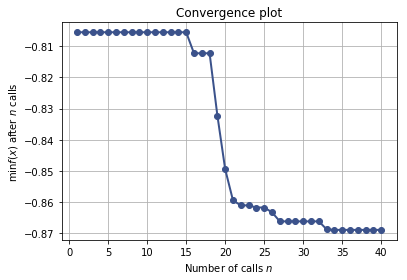

In [9]:
plot_convergence(search_result)
plt.show()

In [10]:
search_result.x

[0.0002770936770006768, 2, 1024, 'relu', 0.1]

In [11]:
model = create_model(learning_rate=search_result.x[0],
                         num_dense_layers=search_result.x[1],
                         num_dense_nodes=search_result.x[2],
                         activation=search_result.x[3],
                         dropout = search_result.x[4])

In [12]:
c_index_result = []
for i in range(1,k+1):
    ix = assignments == i
    training_data = data_x_numeric.loc[~ix]
    testing_data = data_x_numeric.loc[ix]

    t_train = training_data.lday.values
    f_train = training_data.event_os.values
    x_train = training_data[testing_columns].values
    y_train = dp.make_surv_array(t_train,f_train,breaks)

    t_test = testing_data.lday.values
    f_test = testing_data.event_os.values
    x_test = testing_data[testing_columns].values
    y_test = dp.make_surv_array(t_test,f_test,breaks)


        # Use Keras to train the model.
    history = model.fit(x=x_train,y=y_train,epochs=1000,
                        batch_size=216,validation_data=(x_test,y_test),
                        callbacks=[early_stopping])

    y_pred_test = model.predict_proba(x_test)

    out_pred = []
    for h in range(len(y_pred_test)):
        temp = np.cumprod(y_pred_test[h,:])>0.5
        pred = (365/2)*list(temp).count(True)
        out_pred.append(pred)
    c_index = cindex(t_test,out_pred,f_test)
    c_index_result.append(c_index)

Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 5s 12ms/step - loss: 5.6913 - acc: 0.1343 - val_loss: 5.4572 - val_acc: 0.7966
Epoch 2/1000
469/469 [==============================] - 0s 827us/step - loss: 5.0638 - acc: 0.7441 - val_loss: 4.7281 - val_acc: 0.8220
Epoch 3/1000
469/469 [==============================] - 0s 904us/step - loss: 4.2855 - acc: 0.7335 - val_loss: 3.7542 - val_acc: 0.7712
Epoch 4/1000
469/469 [==============================] - 0s 904us/step - loss: 3.3231 - acc: 0.4925 - val_loss: 2.8187 - val_acc: 0.0000e+00
Epoch 5/1000
469/469 [==============================] - 0s 791us/step - loss: 2.5150 - acc: 0.0213 - val_loss: 2.2658 - val_acc: 0.0000e+00
Epoch 6/1000
469/469 [==============================] - 0s 836us/step - loss: 2.0860 - acc: 0.0000e+00 - val_loss: 2.0001 - val_acc: 0.0000e+00
Epoch 7/1000
469/469 [==============================] - 0s 852us/step - loss: 1.8791 - acc: 0.0000e+00 - val_loss: 1.8302 -

469/469 [==============================] - 0s 876us/step - loss: 0.6751 - acc: 0.1386 - val_loss: 1.9518 - val_acc: 0.1186
Epoch 59/1000
469/469 [==============================] - 0s 800us/step - loss: 0.6636 - acc: 0.1578 - val_loss: 1.9695 - val_acc: 0.1017
Epoch 60/1000
469/469 [==============================] - 0s 862us/step - loss: 0.6459 - acc: 0.1258 - val_loss: 2.0008 - val_acc: 0.1102
Epoch 61/1000
469/469 [==============================] - 0s 806us/step - loss: 0.6321 - acc: 0.1642 - val_loss: 2.0461 - val_acc: 0.1695
Epoch 62/1000
469/469 [==============================] - 0s 863us/step - loss: 0.6084 - acc: 0.2367 - val_loss: 2.0721 - val_acc: 0.1695
Epoch 63/1000
469/469 [==============================] - 0s 919us/step - loss: 0.5937 - acc: 0.1962 - val_loss: 2.0778 - val_acc: 0.1271
Epoch 64/1000
469/469 [==============================] - 0s 823us/step - loss: 0.5636 - acc: 0.1599 - val_loss: 2.0940 - val_acc: 0.1271
Epoch 65/1000
469/469 [==============================] 

Epoch 118/1000
469/469 [==============================] - 0s 804us/step - loss: 0.0979 - acc: 0.3475 - val_loss: 3.6993 - val_acc: 0.2203
Train on 469 samples, validate on 118 samples
Epoch 1/1000
469/469 [==============================] - 0s 840us/step - loss: 0.9966 - acc: 0.2687 - val_loss: 0.0803 - val_acc: 0.2034
Epoch 2/1000
469/469 [==============================] - 0s 908us/step - loss: 0.9164 - acc: 0.1940 - val_loss: 0.1004 - val_acc: 0.1780
Epoch 3/1000
469/469 [==============================] - 0s 976us/step - loss: 0.7967 - acc: 0.2217 - val_loss: 0.1274 - val_acc: 0.2288
Epoch 4/1000
469/469 [==============================] - 0s 829us/step - loss: 0.6868 - acc: 0.2601 - val_loss: 0.1668 - val_acc: 0.2034
Epoch 5/1000
469/469 [==============================] - 0s 972us/step - loss: 0.6051 - acc: 0.1770 - val_loss: 0.2565 - val_acc: 0.1102
Epoch 6/1000
469/469 [==============================] - 0s 922us/step - loss: 0.5588 - acc: 0.1386 - val_loss: 0.2203 - val_acc: 0.1949


Epoch 8/1000
470/470 [==============================] - 0s 866us/step - loss: 0.0550 - acc: 0.1617 - val_loss: 0.0703 - val_acc: 0.1538
Epoch 9/1000
470/470 [==============================] - 0s 935us/step - loss: 0.0571 - acc: 0.1957 - val_loss: 0.0572 - val_acc: 0.2051


In [13]:
np.mean(c_index_result)

0.8665967540865068

In [14]:
y_pred_test = model.predict_proba(x_full)
out_pred = []
for h in range(len(y_pred_test)):
    temp = np.cumprod(y_pred_test[h,:])>0.5
    pred = (365/2)*list(temp).count(True)
    out_pred.append(pred)

In [15]:
data_x_numeric["y_pred"] = out_pred
data_x_numeric["check"] = abs(data_x_numeric.lday - data_x_numeric.y_pred)/data_x_numeric.lday
data_x_numeric[["event_os","lday","y_pred"]].to_csv("../output/method10.csv")
data_x_numeric.check.describe()

count    587.000000
mean       6.208126
std       15.976443
min        0.000000
25%        0.329660
50%        1.000000
75%        3.876179
max      152.684211
Name: check, dtype: float64

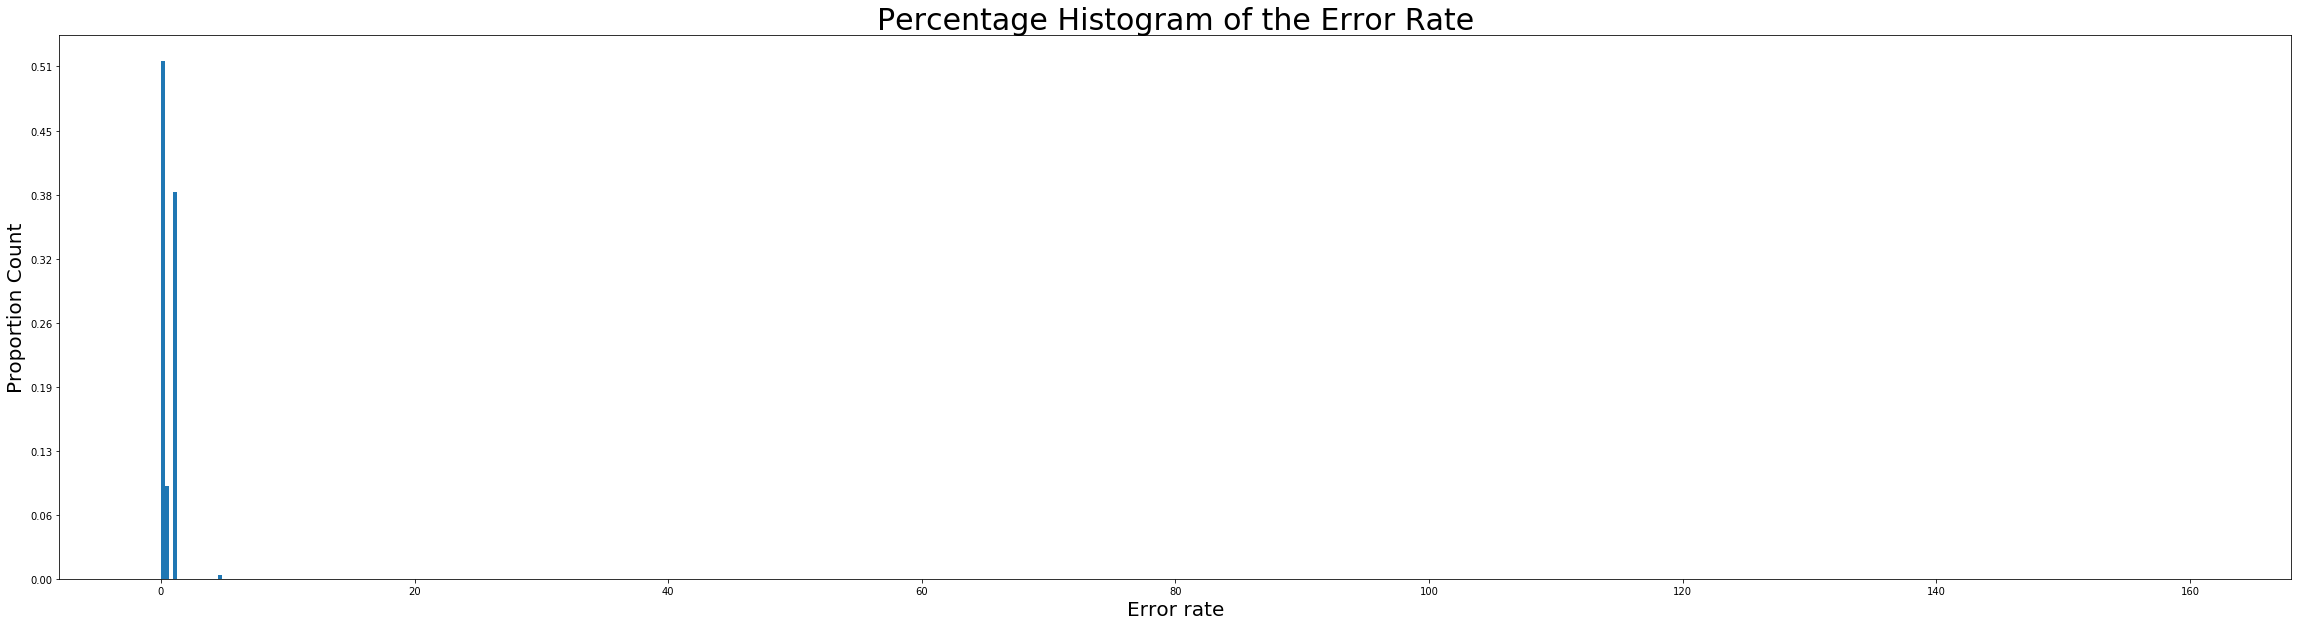

In [68]:
fig = plt.figure(figsize=(40,10))
ax = plt.subplot(111)
ax.hist(df_check["check"],normed=1,range=(0,160),bins=500)
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)
ax_yticklocs = ax.yaxis.get_ticklocs()
ax_yticklocs = list(map(lambda x: x * len(range(0,160))*1.0/500, ax_yticklocs))
ax.yaxis.set_ticklabels(list(map(lambda x: "%0.2f" % x, ax_yticklocs)))
ax.set_xlabel('Error rate',fontsize=20)
ax.set_ylabel('Proportion Count',fontsize=20)
ax.set_title('Percentage Histogram of the Error Rate',fontsize=30)
plt.show()

In [16]:
df_check = data_x_numeric[data_x_numeric.event_os==1]

In [17]:
df_check.check.describe()

count    259.000000
mean       0.505039
std        0.488676
min        0.000000
25%        0.110737
50%        0.306084
75%        1.000000
max        4.554348
Name: check, dtype: float64

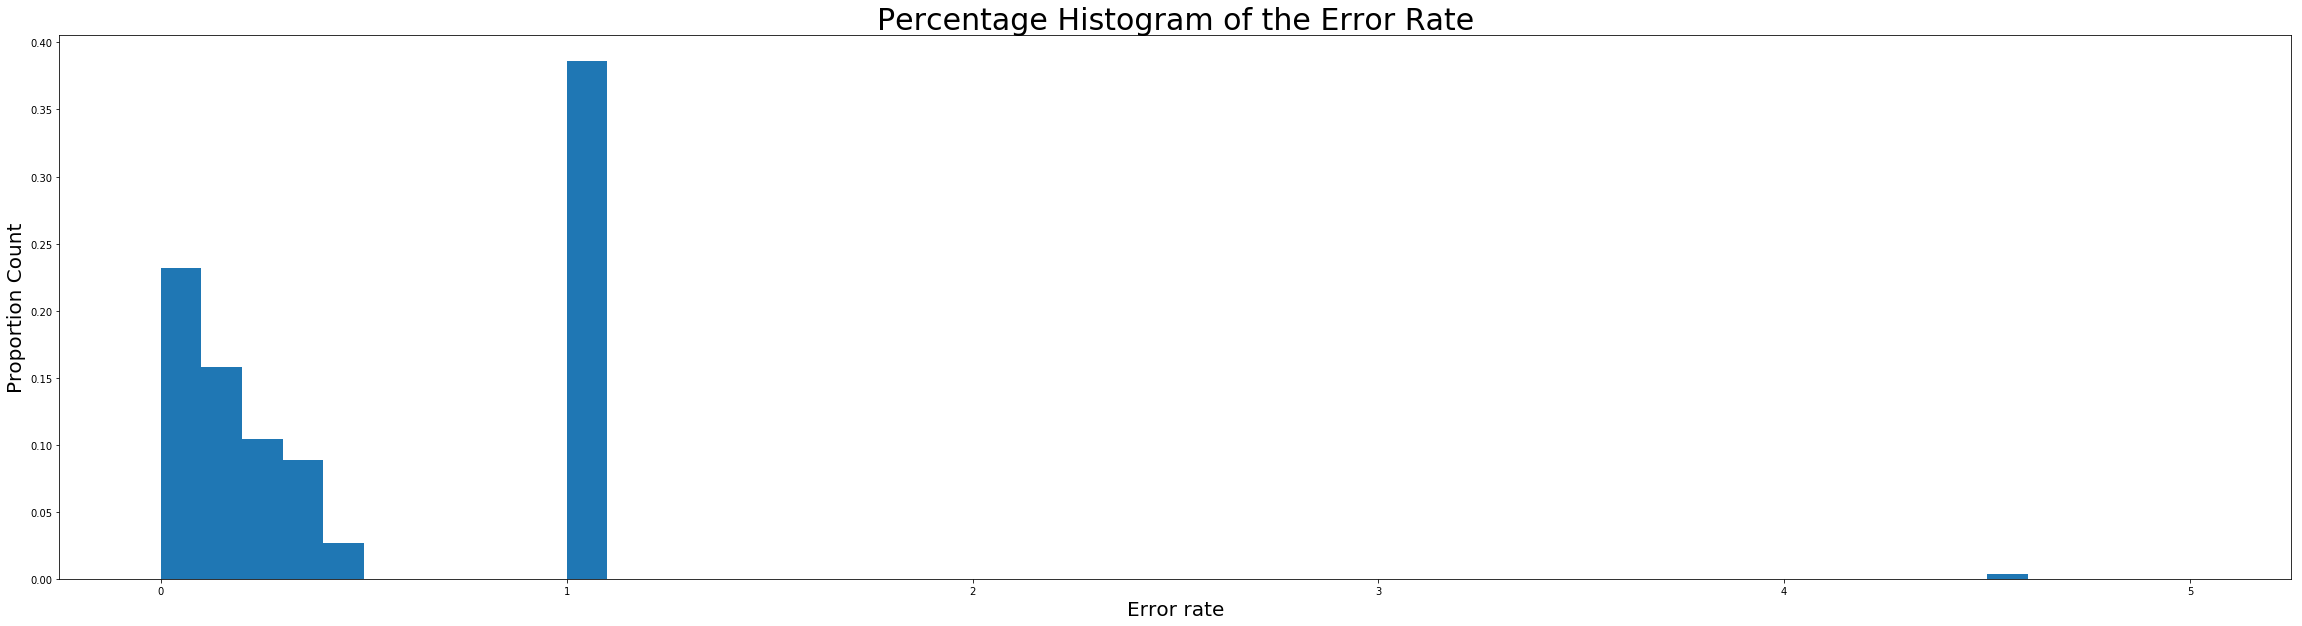

In [66]:
fig = plt.figure(figsize=(40,10))
ax = plt.subplot(111)
ax.hist(df_check["check"],normed=1,range=(0,5),bins=50)
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)
ax_yticklocs = ax.yaxis.get_ticklocs()
ax_yticklocs = list(map(lambda x: x * len(range(0,5))*1.0/50, ax_yticklocs))
ax.yaxis.set_ticklabels(list(map(lambda x: "%0.2f" % x, ax_yticklocs)))
ax.set_xlabel('Error rate',fontsize=20)
ax.set_ylabel('Proportion Count',fontsize=20)
ax.set_title('Percentage Histogram of the Error Rate',fontsize=30)
plt.show()

In [ ]:
# categorize the 2 groups -> from the beginning sorted 
# which patients belongs to which hyping -> maybe parameters 

# Interpretation

In [19]:
explainer = shap.KernelExplainer(model.predict, x_test)

Using 117 background data samples could cause slower run times. Consider using shap.kmeans(data, K) to summarize the background as K weighted samples.


In [20]:
shap_values_test = explainer.shap_values(x_test, nsamples=587)

100%|██████████| 117/117 [47:40<00:00, 25.51s/it]


In [78]:
shap.force_plot(explainer.expected_value[0], shap_values_test[0], x_test[0,:])

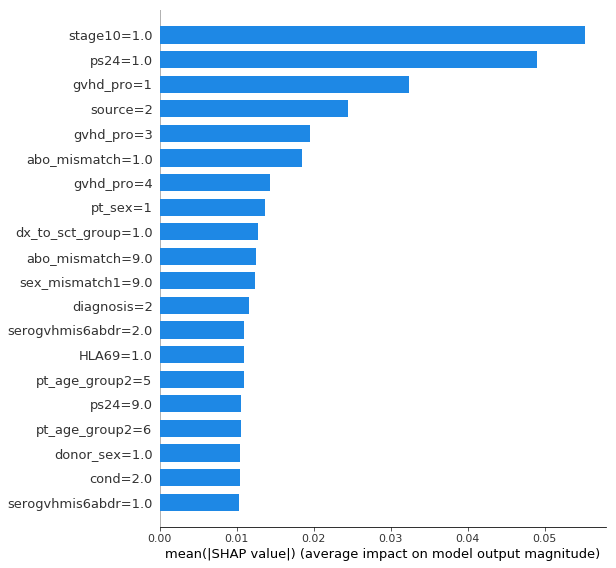

In [69]:
shap.summary_plot(shap_values_test[0],x_test,testing_columns,plot_type="bar")

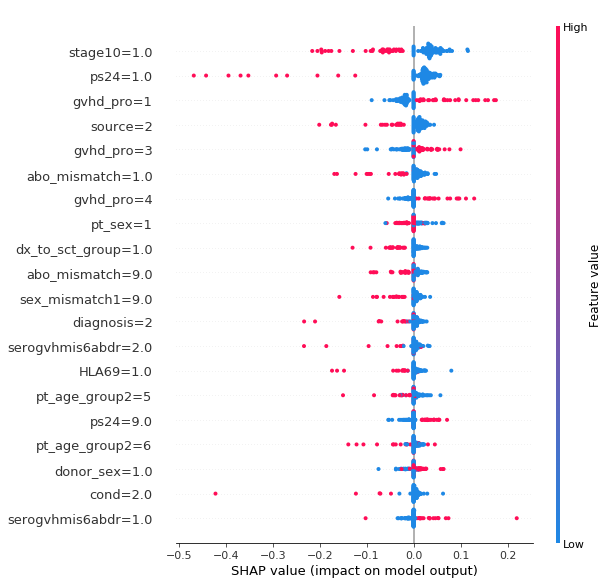

In [23]:
shap.summary_plot(shap_values_test[0],x_test,testing_columns)

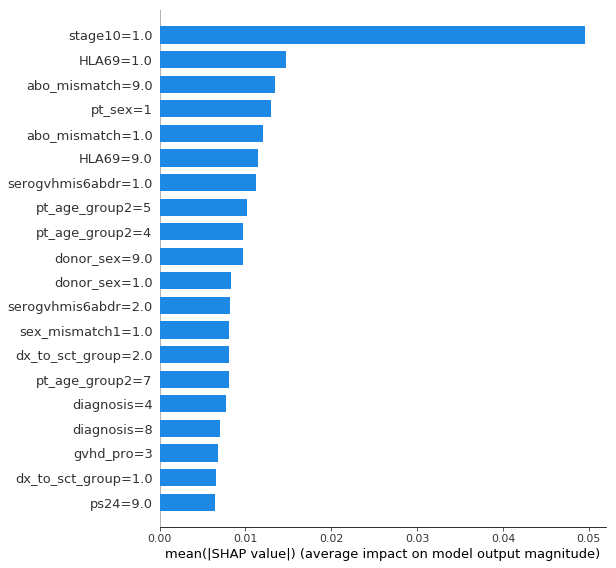

In [70]:
shap.summary_plot(shap_values_test[1],x_test,testing_columns,plot_type="bar")

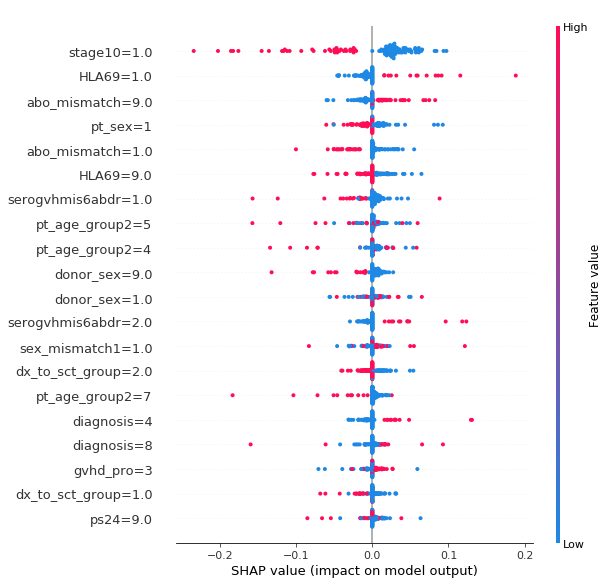

In [71]:
shap.summary_plot(shap_values_test[1],x_test,testing_columns)

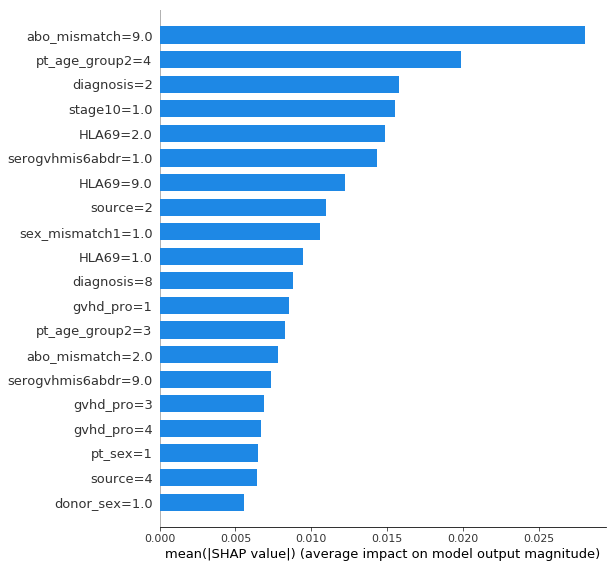

In [72]:
shap.summary_plot(shap_values_test[2],x_test,testing_columns,plot_type="bar")

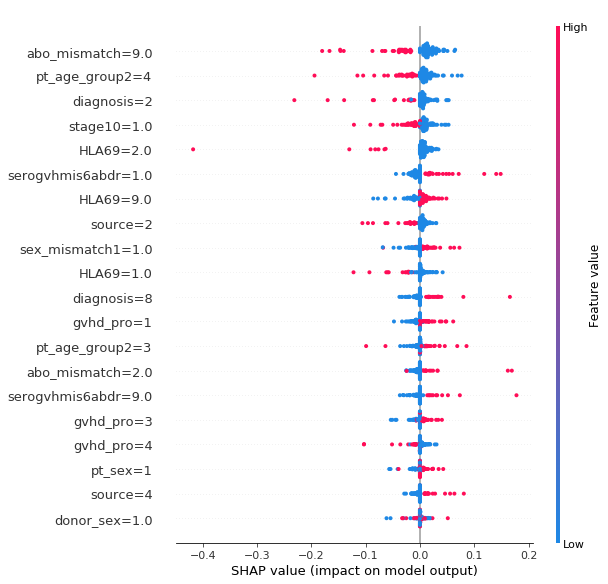

In [73]:
shap.summary_plot(shap_values_test[2],x_test,testing_columns)

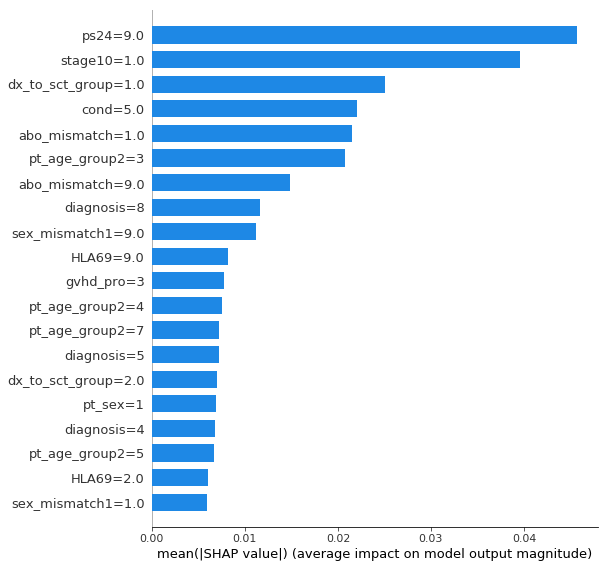

In [74]:
shap.summary_plot(shap_values_test[3],x_test,testing_columns,plot_type="bar")

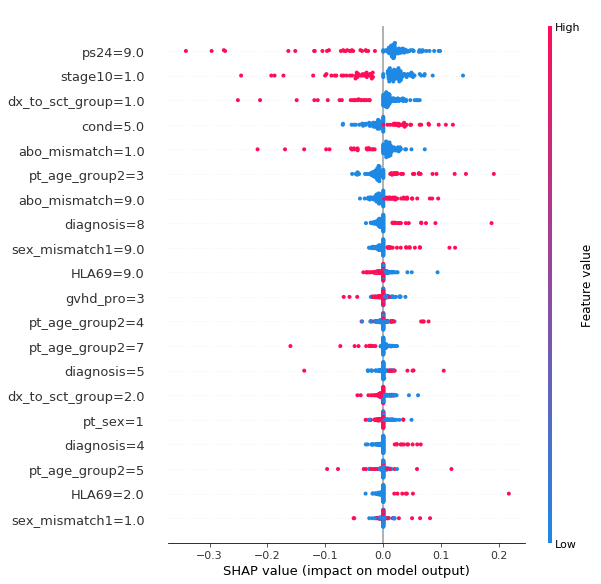

In [75]:
shap.summary_plot(shap_values_test[3],x_test,testing_columns)